In [ ]:
pip install dowhy econml

In [ ]:
pip install thermofeel

##Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
import time
import rasterio
from skimage.measure import block_reduce
import warnings

# =============================================================================
# 1. Configuration Area
# =============================================================================
print("--- 1. 配置路径、变量和参数 ---")

# ⭐ 1. 设置您的项目基础路径
DRIVE_BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Graph Data Process")

# ⭐ 2. 确认分析所需的分辨率
TARGET_RESOLUTION = 128.0  # 目标分辨率 (米)
BASE_RESOLUTION = 4.0      # 原始数据分辨率 (米)

# --- 变量清单 (Variable Lists) ---
# X: 城市形态特征 (Urban Form Features)
X_VARIABLES = [
    'mean_tree_height', 'mean_building_height', 'tree_proportion',
    'building_proportion', 'st1_proportion', 'st2_proportion',
    'st3_proportion', 'st5_proportion'
]
# M: 微气候中介因子 (Microclimate Mediators)
M_VARIABLES = ['air_temp', 'wind_speed', 'relative_humidity', 'MRT']
# Y: 结果变量 (Outcome Variable)
Y_VARIABLE = 'UTCI' # 我们使用之前为UTCI生成的数据

# --- 动态路径配置 (Dynamic Path Configuration) ---
# 输出路径
OUTPUT_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FILE = OUTPUT_DIR / f"panel_data_{int(TARGET_RESOLUTION)}m.parquet"

# 输入路径将根据变量名动态生成
# 我们假设静态特征可以从任一变量的文件夹中获取，这里以air_temp为例
FEATURES_DATA_DIR = DRIVE_BASE_PATH / f"Result/0000Contrast_result/Scale_Analysis/full_timeseries_air_temp"
SPATIAL_INFO_PATH = DRIVE_BASE_PATH / "Result/0000Contrast_result/Final_effectindex/Final_Result/Final_Result_air_temp/spatial_info_cache.pkl"

# =============================================================================
# 2. Main Data Processing Logic
# =============================================================================

def create_panel_data():
    """
    主函数，执行从栅格到面板数据的完整转换流程。
    """
    total_start_time = time.time()

    # --- 2.1: 数据加载与聚合 ---
    print("\n--- [2.1] 开始加载4m数据并聚合至128m ---")

    aggregation_factor = int(TARGET_RESOLUTION / BASE_RESOLUTION)
    block_shape = (aggregation_factor, aggregation_factor)

    # -- a) 加载并聚合静态特征 (X) --
    print("--> 正在处理静态城市形态特征 (X)...")
    features_path = FEATURES_DATA_DIR / "masked_features.npz"
    features_4m = np.load(features_path)

    # 提取基础图层
    tree_height_map_4m = features_4m['tree_height']
    building_height_map_4m = features_4m['building_height']
    landcover_map_4m = features_4m['landcover']

    aggregated_data_dict = {}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # 聚合连续变量
        aggregated_data_dict['mean_tree_height'] = block_reduce(tree_height_map_4m, block_shape, func=np.nanmean)
        aggregated_data_dict['mean_building_height'] = block_reduce(building_height_map_4m, block_shape, func=np.nanmean)

        # 创建二值蒙版以聚合比例变量 (与您提供的代码逻辑完全一致)
        masks_4m = {
            'tree_proportion': (np.nan_to_num(tree_height_map_4m) > 0).astype(np.float32),
            'building_proportion': (np.nan_to_num(building_height_map_4m) > 0).astype(np.float32),
            'st1_proportion': (np.nan_to_num(landcover_map_4m) == 1).astype(np.float32),
            'st2_proportion': (np.nan_to_num(landcover_map_4m) == 2).astype(np.float32),
            'st3_proportion': (np.nan_to_num(landcover_map_4m) == 3).astype(np.float32),
            'st5_proportion': (np.nan_to_num(landcover_map_4m) == 5).astype(np.float32)
        }
        nan_mask_4m = np.isnan(landcover_map_4m)
        for key in masks_4m:
            masks_4m[key][nan_mask_4m] = np.nan
            aggregated_data_dict[key] = block_reduce(masks_4m[key], block_shape, func=np.nanmean)

    # -- b) 生成空间协变量 (Z) --
    print("--> 正在生成空间坐标协变量 (Z)...")
    with open(SPATIAL_INFO_PATH, 'rb') as f:
        spatial_info = pickle.load(f)

    transform_4m = spatial_info['canvas_transform']
    agg_shape = aggregated_data_dict['mean_tree_height'].shape

    # 创建128m分辨率下的像素索引网格
    cols, rows = np.meshgrid(np.arange(agg_shape[1]), np.arange(agg_shape[0]))
    # 将索引乘以聚合因子，以映射回4m分辨率的坐标系，并取中心点
    mapped_cols = cols * aggregation_factor + aggregation_factor / 2
    mapped_rows = rows * aggregation_factor + aggregation_factor / 2

    # 使用rasterio的transform对象将像素坐标转换为真实地理坐标
    x_coords, y_coords = rasterio.transform.xy(transform_4m, mapped_rows, mapped_cols)
    aggregated_data_dict['x_coord'] = np.array(x_coords)
    aggregated_data_dict['y_coord'] = np.array(y_coords)

    # -- c) 加载并聚合时序变量 (Y 和 M) --
    all_time_series_vars = [Y_VARIABLE] + M_VARIABLES
    for var_name in tqdm(all_time_series_vars, desc="处理时序变量"):
        if var_name == 'UTCI':
            # UTCI使用其专用的历史路径
            var_dir = DRIVE_BASE_PATH / "Result/0000Contrast_result/Scale_Analysis/full_timeseries"
        else:
            var_dir = DRIVE_BASE_PATH / f"Result/0000Contrast_result/Scale_Analysis/full_timeseries_{var_name}"

        var_path = var_dir / "masked_variable_timeseries.npy"
        if not var_path.exists():
            # UTCI的旧文件名为masked_utci_timeseries.npy
            var_path = var_dir / "masked_utci_timeseries.npy"
            if not var_path.exists():
                print(f"警告：找不到 {var_name} 的数据文件，将跳过。")
                continue

        var_3d_4m = np.load(var_path)

        # 逐小时聚合
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            agg_var_list = [block_reduce(var_3d_4m[:, :, hour], block_shape, func=np.nanmean) for hour in range(12)]

        # 存储每个小时的聚合结果
        for hour_idx, agg_slice in enumerate(agg_var_list):
            aggregated_data_dict[f'{var_name}_{hour_idx+8}'] = agg_slice # 小时命名为 8 到 19

    # --- 2.2: 构建面板DataFrame ---
    print("\n--- [2.2] 正在将聚合后的数据构建为面板DataFrame ---")

    # -- a) 将所有压平后的一维数组放入字典 --
    flat_data = {key: value.flatten() for key, value in aggregated_data_dict.items()}

    # -- b) 创建宽格式DataFrame --
    print("--> 步骤 1/3: 创建宽格式数据...")
    wide_df = pd.DataFrame(flat_data)
    wide_df['pixel_id'] = np.arange(len(wide_df))

    # -- c) 转换为长格式 (面板数据) --
    print("--> 步骤 2/3: 转换为长格式 (面板数据)...")
    stubnames = all_time_series_vars
    long_df = pd.wide_to_long(
        wide_df,
        stubnames=stubnames,
        i='pixel_id',
        j='hour',
        sep='_',
        suffix=r'\d+'
    ).reset_index()

    # --- 2.3: 清洗与保存 ---
    print("--> 步骤 3/3: 清洗数据并保存到Parquet文件...")

    # 步骤 a): 移除值为 NaN 的行 (以Y变量UTCI为基准)
    df_cleaned = long_df.dropna(subset=[Y_VARIABLE]).copy()
    rows_after_nan_removal = len(df_cleaned)
    print(f"--> 初始长格式数据共 {len(long_df)} 行。")
    print(f"--> 移除了 {len(long_df) - rows_after_nan_removal} 行 UTCI 为 NaN 的数据。")

    # 步骤 b): 根据领域知识，移除 UTCI 为 0 的行 (判定为建筑内部)
    final_df = df_cleaned[df_cleaned[Y_VARIABLE] != 0].copy()
    rows_after_zero_removal = len(final_df)

    # 打印被删除的 UTCI 为 0 的数据行数
    deleted_zero_rows = rows_after_nan_removal - rows_after_zero_removal
    print(f"--> 基于领域知识，移除了 {deleted_zero_rows} 行 UTCI 为 0 的数据 (判定为建筑内部)。")
    print(f"--> 清洗后最终剩余 {rows_after_zero_removal} 行。")


    # 步骤 c): 重命名列以符合 X, M, Y, Z 的框架
    rename_dict = {
        'UTCI': 'Y_utci',
        'air_temp': 'M_air_temp',
        'wind_speed': 'M_wind_speed',
        'relative_humidity': 'M_relative_humidity',
        'MRT': 'M_MRT',
        'x_coord': 'Z_x_coord',
        'y_coord': 'Z_y_coord'
    }
    # 为所有X特征添加'X_'前缀
    for x_var in X_VARIABLES:
        rename_dict[x_var] = f'X_{x_var}'

    final_df.rename(columns=rename_dict, inplace=True)

    # 步骤 d): 重新排列列的顺序，使其更具逻辑性
    column_order = (['pixel_id', 'hour'] +
                    sorted([col for col in final_df.columns if col.startswith('X_')]) +
                    sorted([col for col in final_df.columns if col.startswith('M_')]) +
                    ['Y_utci'] +
                    sorted([col for col in final_df.columns if col.startswith('Z_')]))
    # 确保所有预期的列都存在于DataFrame中，避免KeyError
    valid_column_order = [col for col in column_order if col in final_df.columns]
    final_df = final_df[valid_column_order]

    # 步骤 e): 保存到 Parquet 文件
    final_df.to_parquet(OUTPUT_FILE, index=False)

    total_duration = time.time() - total_start_time
    print("\n" + "="*80)
    print(f"🎉 成功！面板数据已生成。")
    print(f"--> 文件已保存至: {OUTPUT_FILE}")
    print(f"--> 数据表维度: {final_df.shape[0]} 行, {final_df.shape[1]} 列")
    print(f"--> 总耗时: {total_duration:.2f} 秒。")

# =============================================================================
# 3. Execution
# =============================================================================
if __name__ == "__main__":
    create_panel_data()

--- 1. 配置路径、变量和参数 ---

--- [2.1] 开始加载4m数据并聚合至128m ---
--> 正在处理静态城市形态特征 (X)...
--> 正在生成空间坐标协变量 (Z)...


处理时序变量: 100%|██████████| 5/5 [04:24<00:00, 52.88s/it]



--- [2.2] 正在将聚合后的数据构建为面板DataFrame ---
--> 步骤 1/3: 创建宽格式数据...
--> 步骤 2/3: 转换为长格式 (面板数据)...
--> 步骤 3/3: 清洗数据并保存到Parquet文件...
--> 初始长格式数据共 1266000 行。
--> 移除了 681936 行 UTCI 为 NaN 的数据。
--> 基于领域知识，移除了 3000 行 UTCI 为 0 的数据 (判定为建筑内部)。
--> 清洗后最终剩余 581064 行。

🎉 成功！面板数据已生成。
--> 文件已保存至: /content/drive/MyDrive/Colab Notebooks/Graph Data Process/Result/0000Contrast_result/causal_analysis/panel_data_128m.parquet
--> 数据表维度: 581064 行, 17 列
--> 总耗时: 281.96 秒。


Data quality inspection

--- 1. 配置检查脚本所需路径和参数 ---

🚀 开始对文件进行数据质量检查: panel_data_128m.parquet

--- [1] 正在加载数据... ---
✅ 数据加载成功！

--- [2] 数据基础信息概览 ---
--> a) 数据维度 (行, 列): (581064, 17)
--> b) 数据类型和非空值计数:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581064 entries, 0 to 581063
Columns: 17 entries, pixel_id to Z_y_coord
dtypes: float32(13), float64(2), int64(2)
memory usage: 46.5 MB

--> c) 数据集索引信息:
    - 唯一像素点 (pixel_id) 数量: 48422
    - 小时 (hour) 范围: 从 8 到 19

--- [3] 缺失值 (Missing Values) 检查 ---
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []
✅ 恭喜！数据集中没有缺失值。

--- [4] 描述性统计分析 (寻找异常值) ---
--> a) 所有变量的描述性统计:
                            count       mean       std        min        25%  \
pixel_id               581064.000  45805.079 20402.989   2707.000  29592.000   
hour                   581064.000     13.500     3.452      8.000     10.750   
X_building_proportion  581064.000      0.155     0.211      0.000      0.000   
X_mean_building_height 581064.000      2.823     4.938      0.000     

/tmp/ipython-input-468176039.py:95: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:95: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:95: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:95: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:95: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:95: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,

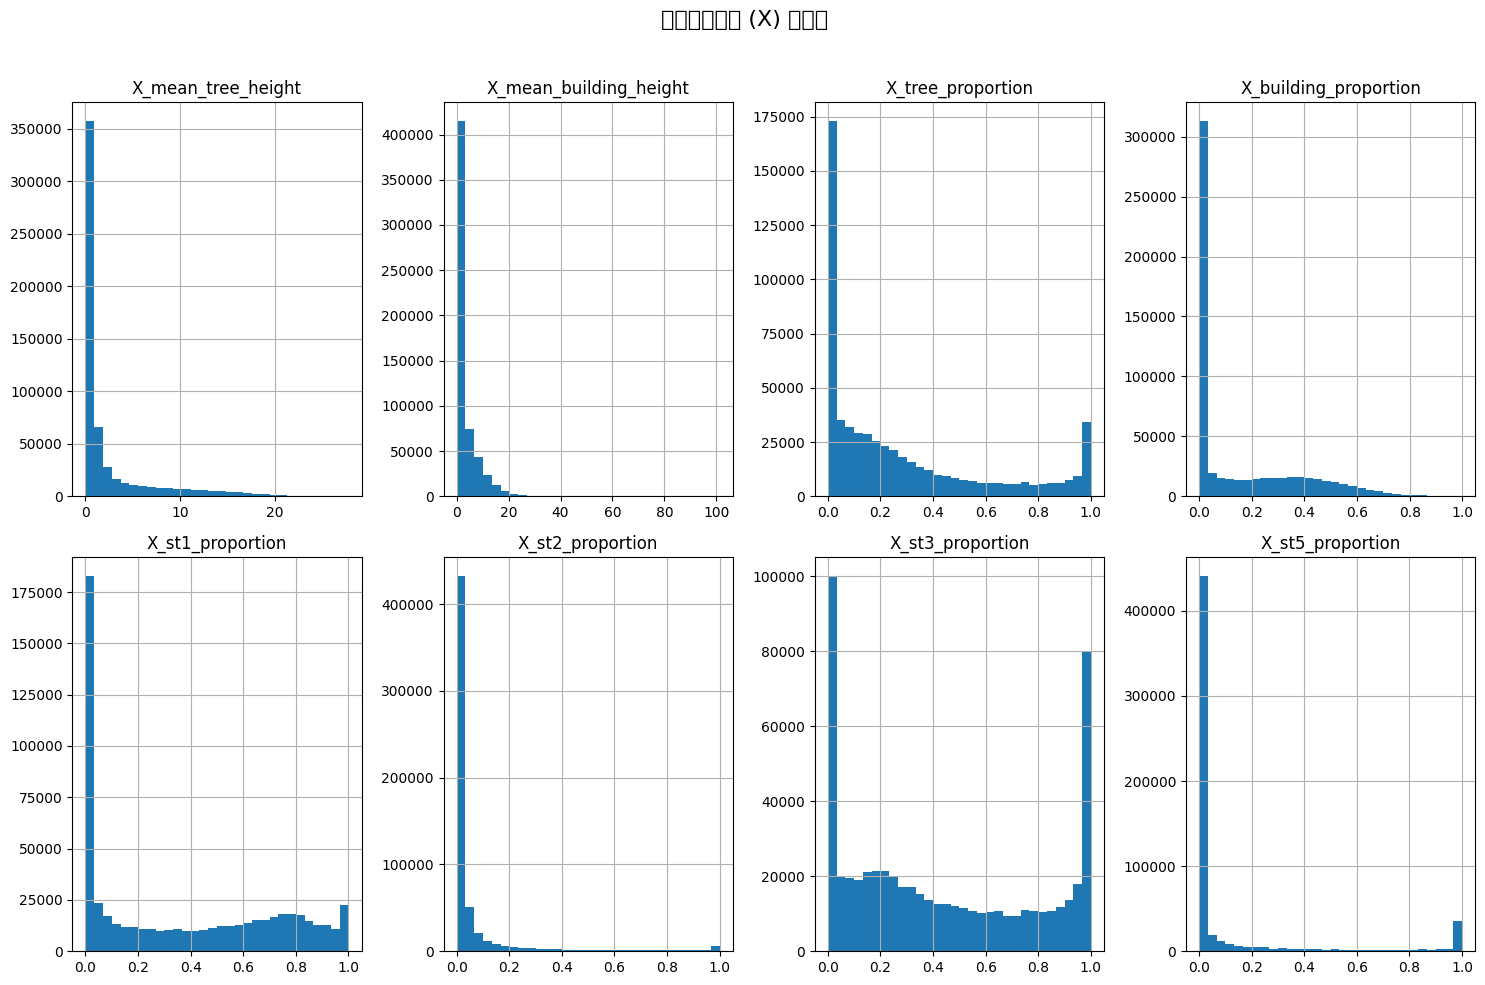

/tmp/ipython-input-468176039.py:101: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:101: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:101: UserWarning: Glyph 20505 (\N{CJK UNIFIED IDEOGRAPH-5019}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:101: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:101: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-468176039.py:101: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(re

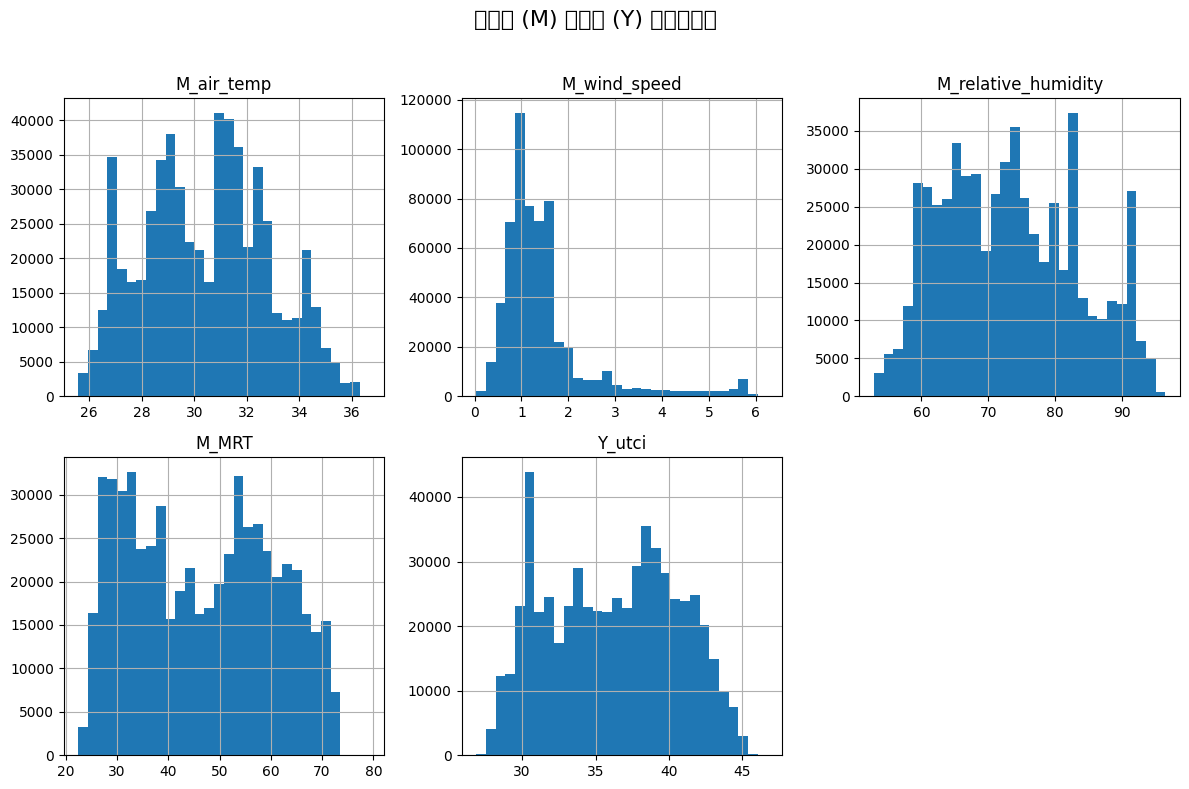

🔎 **检查点**: 
   - 分布是否符合预期？（例如，是否为正态分布、偏态分布或双峰分布）
   - 是否有异常的“长尾”或离群点？

--- [6] 特征相关性分析 ---
正在计算并绘制相关性热力图...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas

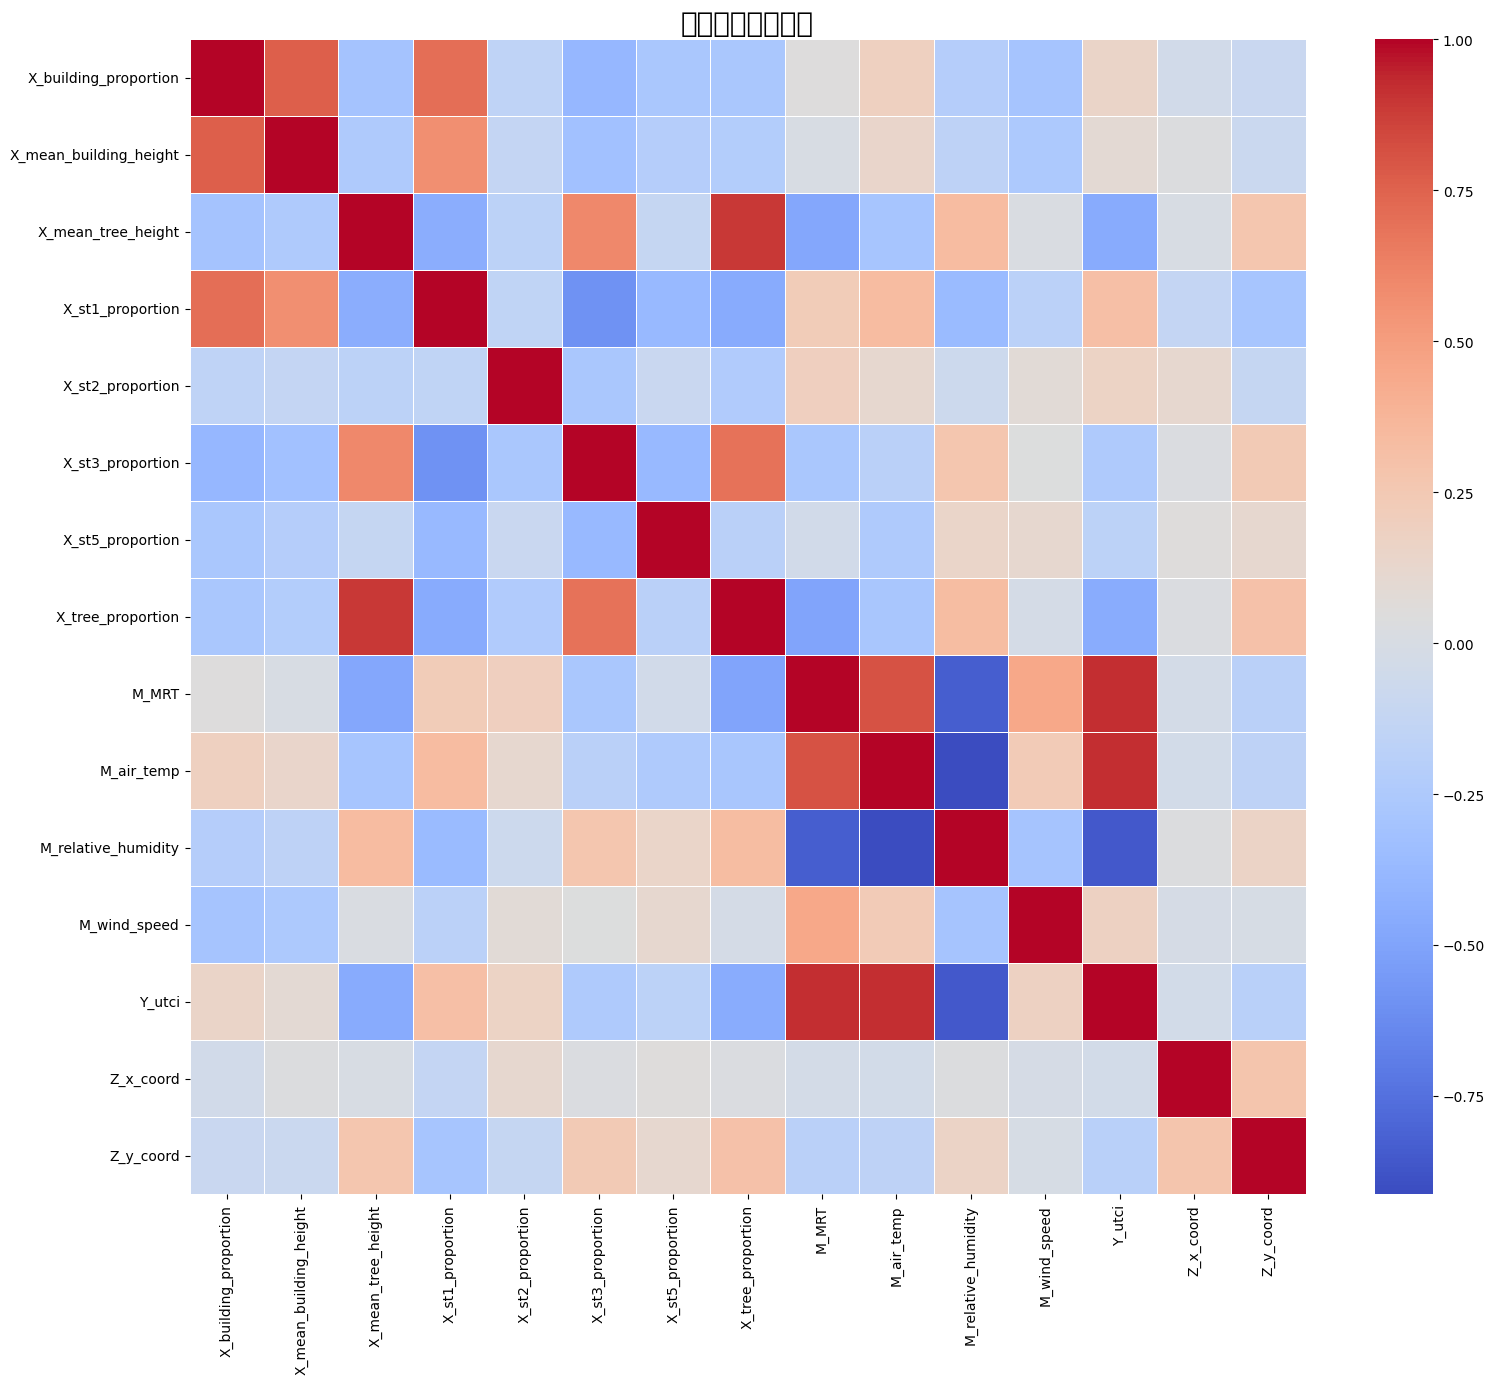

🔎 **检查点**: 
   - 是否存在高度相关的自变量 (X变量之间)？这可能导致多重共线性问题。
   - 你的Y变量与哪些X和M变量相关性最高？是否符合你的初步假设？

--> 高度相关 (corr > 0.85) 的变量对:
Y_utci              M_air_temp            0.924
M_MRT               Y_utci                0.923
M_air_temp          M_relative_humidity   0.913
X_mean_tree_height  X_tree_proportion     0.893
Y_utci              M_relative_humidity   0.860
dtype: float64

--- [7] 时序行为检查 (按小时聚合) ---
正在绘制M和Y变量随时间变化的趋势图...


/tmp/ipython-input-468176039.py:143: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-468176039.py:143: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-468176039.py:143: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-468176039.py:143: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-468176039.py:143: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-468176039.py:143: UserWarning: Glyph 25353 (\N{CJK UNIFIED IDEOGRAPH-6309}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-468176039.py:143: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missi

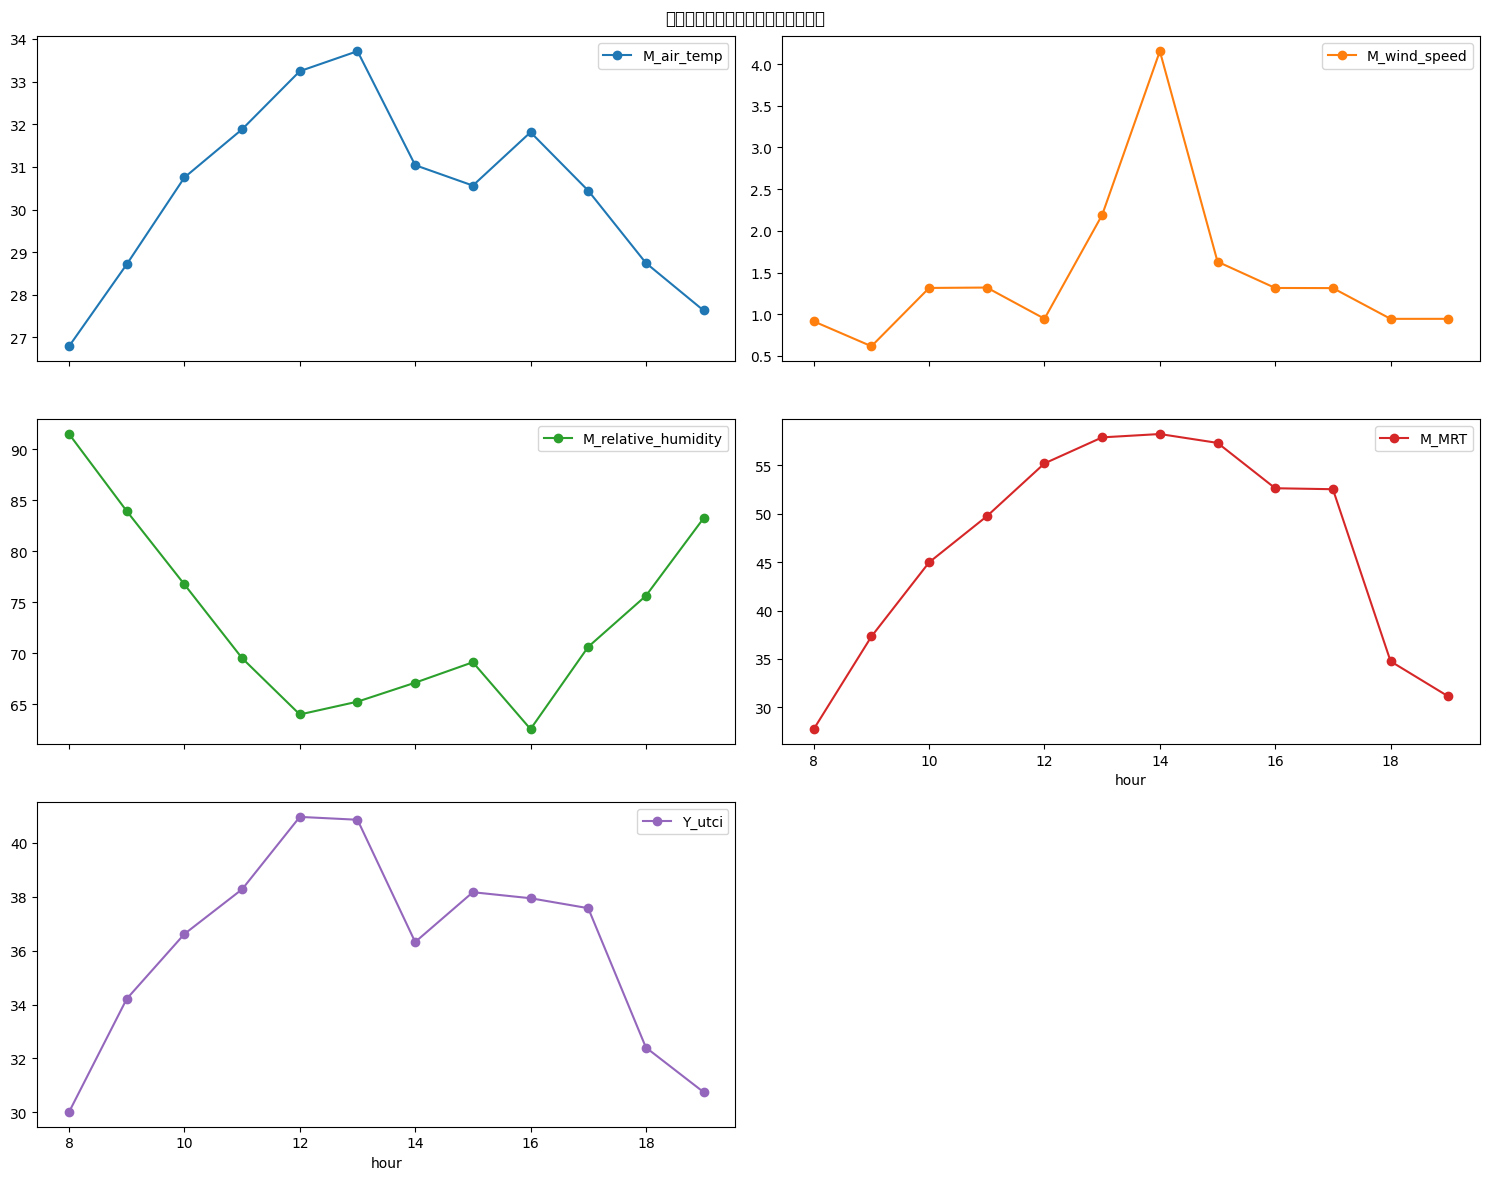

🔎 **检查点**: 
   - 变量的时间趋势是否符合物理或常识？(例如, 气温是否在午后达到峰值?)
   - 是否有某个小时的数据出现异常的尖峰或断崖？

🎉 数据质量检查完成！


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# =============================================================================
# 1. Configuration Area
# =============================================================================
print("--- 1. 配置检查脚本所需路径和参数 ---")

# ⭐ 1. 设置您的项目基础路径 (请确保与数据生成脚本一致)
DRIVE_BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Graph Data Process")

# ⭐ 2. 设置被检查文件的分辨率
TARGET_RESOLUTION = 128.0

# --- 路径配置 ---
# 输入文件路径 (由您的上一个脚本生成)
INPUT_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis"
INPUT_FILE = INPUT_DIR / f"panel_data_{int(TARGET_RESOLUTION)}m.parquet"

# --- 变量清单 (用于分组报告) ---
X_VARIABLES = [
    'X_mean_tree_height', 'X_mean_building_height', 'X_tree_proportion',
    'X_building_proportion', 'X_st1_proportion', 'X_st2_proportion',
    'X_st3_proportion', 'X_st5_proportion'
]
M_VARIABLES = ['M_air_temp', 'M_wind_speed', 'M_relative_humidity', 'M_MRT']
Y_VARIABLE = ['Y_utci']
Z_VARIABLES = ['Z_x_coord', 'Z_y_coord']


def run_data_quality_check(file_path):
    """
    主函数，用于执行完整的数据质量检查流程。
    """
    print("\n" + "="*80)
    print(f"🚀 开始对文件进行数据质量检查: {file_path.name}")
    print("="*80)

    # --- 1. 数据加载 ---
    if not file_path.exists():
        print(f"❌ 错误：找不到数据文件！请检查路径: {file_path}")
        return

    print("\n--- [1] 正在加载数据... ---")
    df = pd.read_parquet(file_path)
    print("✅ 数据加载成功！")

    # --- 2. 基础信息概览 ---
    print("\n--- [2] 数据基础信息概览 ---")
    print("--> a) 数据维度 (行, 列):", df.shape)
    print("--> b) 数据类型和非空值计数:")
    df.info(verbose=False) # 使用verbose=False使其更简洁
    print("\n--> c) 数据集索引信息:")
    num_pixels = df['pixel_id'].nunique()
    hour_range = (df['hour'].min(), df['hour'].max())
    print(f"    - 唯一像素点 (pixel_id) 数量: {num_pixels}")
    print(f"    - 小时 (hour) 范围: 从 {hour_range[0]} 到 {hour_range[1]}")
    if df.shape[0] != num_pixels * (hour_range[1] - hour_range[0] + 1):
        print("    - ⚠️ 警告: 数据似乎不是一个平衡面板 (行数 != 像素数 * 小时数)。这可能是由dropna操作导致的，通常是正常的。")

    # --- 3. 缺失值检查 ---
    print("\n--- [3] 缺失值 (Missing Values) 检查 ---")
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({'missing_count': df.isnull().sum(), 'missing_percentage': missing_percentage})
    print(missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_count', ascending=False))
    if missing_df['missing_count'].sum() == 0:
        print("✅ 恭喜！数据集中没有缺失值。")

    # --- 4. 描述性统计分析 ---
    print("\n--- [4] 描述性统计分析 (寻找异常值) ---")
    # 设置Pandas显示格式
    pd.options.display.float_format = '{:.3f}'.format
    print("--> a) 所有变量的描述性统计:")
    print(df.describe().T)
    print("\n🔎 **检查点**: ")
    print("   - `std` (标准差) 是否为 0？这代表该列是常量，对于因果分析是无效特征。")
    print("   - `min` 和 `max` 是否在合理范围内？(例如，比例应在0-1之间，湿度不应>100)")
    # 检查常量列
    constant_columns = df.columns[df.nunique() <= 1]
    if not constant_columns.empty:
        print(f"\n   - ⚠️ **警告**: 发现常量列: {list(constant_columns)}")
    else:
        print("   - ✅ 未发现常量列。")

    # --- 5. 数据分布可视化 ---
    print("\n--- [5] 数据分布可视化 ---")
    print("正在生成变量分布直方图... (图表将弹出显示)")

    # 绘制X变量
    df[X_VARIABLES].hist(bins=30, figsize=(15, 10), layout=(-1, 4))
    plt.suptitle("城市形态特征 (X) 的分布", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 绘制M和Y变量
    df[M_VARIABLES + Y_VARIABLE].hist(bins=30, figsize=(12, 8), layout=(-1, 3))
    plt.suptitle("微气候 (M) 与结果 (Y) 变量的分布", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print("🔎 **检查点**: ")
    print("   - 分布是否符合预期？（例如，是否为正态分布、偏态分布或双峰分布）")
    print("   - 是否有异常的“长尾”或离群点？")

    # --- 6. 相关性分析 ---
    print("\n--- [6] 特征相关性分析 ---")
    print("正在计算并绘制相关性热力图...")

    # 只选择数值型变量进行相关性分析
    numerical_cols = df.select_dtypes(include=np.number).columns.drop(['pixel_id', 'hour'])
    correlation_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
    plt.title('特征相关性热力图', fontsize=20)
    plt.show()

    print("🔎 **检查点**: ")
    print("   - 是否存在高度相关的自变量 (X变量之间)？这可能导致多重共线性问题。")
    print("   - 你的Y变量与哪些X和M变量相关性最高？是否符合你的初步假设？")
    # 找出高度相关的变量对
    high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
    high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.85] # 阈值可调
    high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0] # 排除自身与自身的完美相关
    print("\n--> 高度相关 (corr > 0.85) 的变量对:")
    print(high_corr_pairs.drop_duplicates())


    # --- 7. 时序行为检查 ---
    print("\n--- [7] 时序行为检查 (按小时聚合) ---")
    print("正在绘制M和Y变量随时间变化的趋势图...")

    # 按小时对M和Y变量进行分组求平均
    hourly_mean = df.groupby('hour')[M_VARIABLES + Y_VARIABLE].mean()

    hourly_mean.plot(kind='line', subplots=True, figsize=(15, 12), layout=(3, 2),
                     title="各时序变量按小时的平均值变化趋势", style='-o',
                     sharex=True)
    plt.xlabel("小时 (Hour)")
    plt.tight_layout()
    plt.show()

    print("🔎 **检查点**: ")
    print("   - 变量的时间趋势是否符合物理或常识？(例如, 气温是否在午后达到峰值?)")
    print("   - 是否有某个小时的数据出现异常的尖峰或断崖？")

    print("\n" + "="*80)
    print("🎉 数据质量检查完成！")
    print("="*80)

# =============================================================================
# 3. Execution
# =============================================================================
if __name__ == "__main__":
    run_data_quality_check(INPUT_FILE)

## Causal discovery and global model construction



In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import matplotlib.lines as mlines
import json
import pydot

# 导入必要的库
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

# 导入因果发现库
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.cit import fisherz
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.Edge import Edge

# =============================================================================
# 辅助函数定义
# =============================================================================

def format_causallearn_edges(graph_obj, labels):
    """将causal-learn图对象的边转换为可读的字典列表。"""
    edges_list = []
    edges = graph_obj.get_graph_edges()
    for edge in edges:
        source_name = edge.get_node1().get_name()
        target_name = edge.get_node2().get_name()

        # 将内部的 X1, X2... 名称映射回可读的 labels
        source_idx = int(source_name.replace('X', '')) - 1
        target_idx = int(target_name.replace('X', '')) - 1

        edges_list.append({
            "source": labels[source_idx],
            "target": labels[target_idx],
            "endpoint1": edge.get_endpoint1().name,
            "endpoint2": edge.get_endpoint2().name
        })
    return edges_list

def create_synthesis_graph(pc_graph_obj, fci_graph_obj, labels):
    """根据PC和FCI的结果，创建综合结论图及其结构化信息。"""
    synthesis_dot = pydot.Dot("synthesis_graph", graph_type="digraph", rankdir="TB", overlap="false", splines="true")
    num_nodes = len(labels)
    nodes = pc_graph_obj.get_nodes()
    synthesis_edges = []

    for label in labels:
        synthesis_dot.add_node(pydot.Node(label, shape='ellipse'))

    processed_bidirected = set()
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j: continue

            node1, node2 = nodes[i], nodes[j]
            label1, label2 = labels[i], labels[j]
            pair_key = tuple(sorted((label1, label2)))

            pc_is_directed_ij = pc_graph_obj.is_directed_from_to(node1, node2)
            pc_is_directed_ji = pc_graph_obj.is_directed_from_to(node2, node1)
            fci_edge = fci_graph_obj.get_edge(node1, node2)

            # 规则 C (被混淆)
            if fci_edge and fci_edge.get_endpoint1() == Endpoint.ARROW and fci_edge.get_endpoint2() == Endpoint.ARROW:
                if pair_key not in processed_bidirected:
                    synthesis_dot.add_edge(pydot.Edge(label1, label2, style="solid", color="red", dir="both"))
                    synthesis_edges.append({"source": label1, "target": label2, "type": "confounded"})
                    processed_bidirected.add(pair_key)
                continue

            # 规则 B (不确定)
            if (pc_is_directed_ij or pc_is_directed_ji) and fci_edge and (fci_edge.get_endpoint1() == Endpoint.CIRCLE or fci_edge.get_endpoint2() == Endpoint.CIRCLE):
                if pc_is_directed_ij:
                    synthesis_dot.add_edge(pydot.Edge(label1, label2, style="dashed", color="black"))
                    synthesis_edges.append({"source": label1, "target": label2, "type": "uncertain"})
                else:
                    synthesis_dot.add_edge(pydot.Edge(label2, label1, style="dashed", color="black"))
                    synthesis_edges.append({"source": label2, "target": label1, "type": "uncertain"})
                continue

            # 规则 A (一致)
            fci_is_directed_ij = fci_graph_obj.is_directed_from_to(node1, node2)
            if pc_is_directed_ij and fci_is_directed_ij:
                synthesis_dot.add_edge(pydot.Edge(label1, label2, style="solid", color="black"))
                synthesis_edges.append({"source": label1, "target": label2, "type": "solid"})

    return synthesis_dot, synthesis_edges

def apply_final_causal_corrections(graph_obj, m_nodes, y_node):
    """
    在causal-learn图对象上，直接进行外科手术式修正，强制 M -> Y 的边。
    """
    # 1. 清理：遍历所有M节点，删除任何与Y节点之间已存在的、不正确的边
    for m_node in m_nodes:
        existing_edge = graph_obj.get_edge(m_node, y_node)
        if existing_edge:
            graph_obj.remove_edge(existing_edge)

    # 2. 添加：为每个M节点，添加一条确定的 M -> Y 的边
    for m_node in m_nodes:
        # 创建一条从 M 到 Y 的新边，端点为 TAIL (--) 和 ARROW (>)
        new_edge = Edge(m_node, y_node, Endpoint.TAIL, Endpoint.ARROW)
        graph_obj.add_edge(new_edge)

    return graph_obj

# =============================================================================
# 1. Configuration Area
# =============================================================================
print("--- 1. 配置路径、变量和参数 ---")

DRIVE_BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Graph Data Process")
PANEL_DATA_PATH = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis/panel_data_128m.parquet"
OUTPUT_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis/step1_2_outputs_v_final_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CAUSAL_GRAPHS_DIR = OUTPUT_DIR / "causal_graphs"
CAUSAL_INFO_DIR = OUTPUT_DIR / "causal_info_json"
MODELS_DIR = OUTPUT_DIR / "trained_models"
CAUSAL_GRAPHS_DIR.mkdir(exist_ok=True)
CAUSAL_INFO_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

X_COLS = [f'X_{p}' for p in ['mean_tree_height', 'mean_building_height', 'tree_proportion', 'building_proportion', 'st1_proportion', 'st2_proportion', 'st3_proportion', 'st5_proportion']]
M_COLS = ['M_air_temp', 'M_wind_speed', 'M_relative_humidity', 'M_MRT']
Y_COLS = ['Y_utci']
Z_COLS = ['Z_x_coord', 'Z_y_coord']

DISCOVERY_NODES = X_COLS + Z_COLS + M_COLS + Y_COLS
ALPHA_LEVEL = 0.05

# =============================================================================
# 2. Main Execution Workflow
# =============================================================================
def main_workflow():
    total_start_time = time.time()

    # --- Part 1: 数据加载与标准化 ---
    print("\n" + "="*80 + "\n▶️ [Part 1] 正在加载并标准化面板数据...")
    df = pd.read_parquet(PANEL_DATA_PATH)
    cols_to_scale = X_COLS + M_COLS + Y_COLS + Z_COLS
    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    joblib.dump(scaler, MODELS_DIR / "standard_scaler.joblib")
    print("✅ 数据标准化完成。")

    # --- Part 2: 逐时因果结构发现 ---
    print("\n" + "="*80 + "\n▶️ [Part 2] 正在进行逐时因果结构发现...")

    # --- a. 构建先验知识 (只含禁止规则) ---
    print("--> 正在构建禁止规则先验知识约束...")
    print("    - 步骤 1/2: 运行“虚拟”PC以获取官方节点对象...")
    df_hour_for_nodes = df[df['hour'] == 8].copy()
    data_for_nodes = QuantileTransformer(output_distribution='normal', random_state=42).fit_transform(df_hour_for_nodes[DISCOVERY_NODES])
    cg_dummy = pc(data_for_nodes, alpha=ALPHA_LEVEL, indep_test=fisherz, show_progress=False)
    all_nodes = cg_dummy.G.get_nodes()
    print(f"    - 成功获取 {len(all_nodes)} 个官方节点对象。")

    print("    - 步骤 2/2: 使用官方节点构建禁止规则库...")
    knowledge = BackgroundKnowledge()
    len_x, len_z, len_m, _ = len(X_COLS), len(Z_COLS), len(M_COLS), len(Y_COLS)
    x_indices, z_indices = list(range(len_x)), list(range(len_x, len_x + len_z))
    m_indices, y_indices = list(range(len_x + len_z, len_x + len_z + len_m)), list(range(len_x + len_z + len_m, len(DISCOVERY_NODES)))
    tier1_indices = x_indices + z_indices
    for i in range(len(tier1_indices)):
        for j in range(i + 1, len(tier1_indices)):
            knowledge.add_forbidden_by_node(all_nodes[tier1_indices[i]], all_nodes[tier1_indices[j]])
            knowledge.add_forbidden_by_node(all_nodes[tier1_indices[j]], all_nodes[tier1_indices[i]])
    for m_idx in m_indices:
        for t1_idx in tier1_indices: knowledge.add_forbidden_by_node(all_nodes[m_idx], all_nodes[t1_idx])
    for y_idx in y_indices:
        for t1_idx in tier1_indices: knowledge.add_forbidden_by_node(all_nodes[y_idx], all_nodes[t1_idx])
        for m_idx in m_indices: knowledge.add_forbidden_by_node(all_nodes[y_idx], all_nodes[m_idx])
    for t1_idx in tier1_indices:
        for y_idx in y_indices:
            knowledge.add_forbidden_by_node(all_nodes[t1_idx], all_nodes[y_idx])
            knowledge.add_forbidden_by_node(all_nodes[y_idx], all_nodes[t1_idx])
    print("--> 先验知识构建完成。")
    print("    - 开始逐时因果发现...")

    # 预先获取 M 和 Y 的节点对象，供后续修正使用
    m_nodes_for_correction = [all_nodes[i] for i in m_indices]
    y_node_for_correction = all_nodes[y_indices[0]]

    for hour in tqdm(range(8, 20), desc="处理小时"):
        df_hour = df[df['hour'] == hour].copy()
        print(f"\n--- 处理小时: {hour}:00 ---")
        # # --- 新增：绘制 M+Y 分布对比图 ---
        # print("      - 正在生成 M+Y 分布对比图...")
        # data_before_sampled = df_hour[DISTRIBUTION_PLOT_NODES].sample(
        #     n=min(SAMPLING_SIZE_FOR_PLOTS, len(df_hour)), random_state=42
        # )
        # qt_viz = QuantileTransformer(output_distribution='normal', random_state=42)
        # data_after_sampled = pd.DataFrame(qt_viz.fit_transform(data_before_sampled), columns=DISTRIBUTION_PLOT_NODES)

        # g = sns.PairGrid(data=data_before_sampled, vars=DISTRIBUTION_PLOT_NODES)
        # for i in range(len(DISTRIBUTION_PLOT_NODES)):
        #     for j in range(len(DISTRIBUTION_PLOT_NODES)):
        #         ax = g.axes[i, j]
        #         var_y, var_x = DISTRIBUTION_PLOT_NODES[i], DISTRIBUTION_PLOT_NODES[j]
        #         if i == j:
        #             sns.kdeplot(data=data_before_sampled, x=var_x, color='red', ax=ax)
        #             sns.kdeplot(data=data_after_sampled, x=var_x, color='black', ax=ax)
        #         else:
        #             sns.kdeplot(data=data_before_sampled, x=var_x, y=var_y, color='red', ax=ax)
        #             sns.kdeplot(data=data_after_sampled, x=var_x, y=var_y, color='black', ax=ax)

        # red_line = mlines.Line2D([], [], color='red', label='Before Transformation')
        # black_line = mlines.Line2D([], [], color='black', label='After Transformation')
        # g.fig.legend(handles=[red_line, black_line], loc='upper right', bbox_to_anchor=(0.95, 0.95))
        # g.fig.suptitle(f'M+Y Distribution Before (Red) & After (Black) Transformation at {hour}:00', y=1.02)
        # g.savefig(DIST_PLOTS_DIR / f'distribution_transform_hour_{hour}.png', dpi=150)
        # plt.close(g.fig)
        # # --- 绘图代码结束 ---
        data_for_discovery = QuantileTransformer(output_distribution='normal', random_state=42).fit_transform(df_hour[DISCOVERY_NODES])

        print("    - 正在运行 PC 和 FCI 算法...")
        cg_pc = pc(data_for_discovery, alpha=ALPHA_LEVEL, indep_test=fisherz, background_knowledge=knowledge, show_progress=False)
        cg_fci, _ = fci(data_for_discovery, alpha=ALPHA_LEVEL, indep_test=fisherz, background_knowledge=knowledge, show_progress=False)

        # --- 新增：在可视化前，对图数据结构进行直接修正 ---
        print("    - 正在对因果图数据结构进行后处理修正 (M->Y)...")
        cg_pc.G = apply_final_causal_corrections(cg_pc.G, m_nodes_for_correction, y_node_for_correction)
        cg_fci = apply_final_causal_corrections(cg_fci, m_nodes_for_correction, y_node_for_correction)

        print("    - 正在生成并保存 PC, FCI 及综合因果图...")
        pydot_pc = GraphUtils.to_pydot(cg_pc.G, labels=DISCOVERY_NODES)
        pydot_pc.write_png(str(CAUSAL_GRAPHS_DIR / f'pc_causal_graph_hour_{hour}.png'))

        pydot_fci = GraphUtils.to_pydot(cg_fci, labels=DISCOVERY_NODES)
        pydot_fci.write_png(str(CAUSAL_GRAPHS_DIR / f'fci_causal_graph_hour_{hour}.png'))

        # 综合图现在使用修正后的图对象作为输入
        synthesis_graph, synthesis_edges = create_synthesis_graph(cg_pc.G, cg_fci, DISCOVERY_NODES)
        synthesis_graph.write_png(str(CAUSAL_GRAPHS_DIR / f'synthesis_causal_graph_hour_{hour}.png'))

        # --- 简化JSON保存，直接使用修正后的图对象 ---
        print("    - 正在保存修正后的结构化因果信息到 JSON...")
        pc_info = {"nodes": DISCOVERY_NODES, "edges": format_causallearn_edges(cg_pc.G, DISCOVERY_NODES)}
        fci_info = {"nodes": DISCOVERY_NODES, "edges": format_causallearn_edges(cg_fci, DISCOVERY_NODES)}
        synthesis_info = {"nodes": DISCOVERY_NODES, "edges": synthesis_edges}

        with open(CAUSAL_INFO_DIR / f'pc_info_hour_{hour:02d}.json', 'w') as f: json.dump(pc_info, f, indent=4)
        with open(CAUSAL_INFO_DIR / f'fci_info_hour_{hour:02d}.json', 'w') as f: json.dump(fci_info, f, indent=4)
        with open(CAUSAL_INFO_DIR / f'synthesis_info_hour_{hour:02d}.json', 'w') as f: json.dump(synthesis_info, f, indent=4)

    print(f"✅ 逐时因果发现完成。所有产出已保存。")

    # # --- Part 3: 分时段预测模型构建 (含自动化调优) ---
    # print("\n" + "="*80 + "\n▶️ [Part 3] 正在构建分时段预测模型...")

    # # --- 步骤 3.1: 一次性超参数调优 ---
    # print("--> 步骤 3.1: 为 M 模型进行一次性全局超参数调优...")
    # param_dist = {
    #     'n_estimators': [100, 200, 300, 400],
    #     'learning_rate': [0.01, 0.05, 0.1, 0.2],
    #     'max_depth': [3, 5, 7, 9, 11],
    #     'subsample': [0.7, 0.8, 0.9, 1.0],
    #     'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    # }
    # xgb_base_m_tune = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    # random_search = RandomizedSearchCV(estimator=xgb_base_m_tune, param_distributions=param_dist, n_iter=25, cv=3, verbose=1, random_state=42, n_jobs=-1)

    # # 使用完整的 M 模型训练数据进行调优
    # features_m_full = df[X_COLS + Z_COLS]; targets_m_full = df[M_COLS]
    # random_search.fit(features_m_full, targets_m_full.iloc[:, 0]) # 以第一个目标作为代理

    # best_params_m = random_search.best_params_
    # print(f"    - 调优完成。找到的最佳参数为: {best_params_m}")

    # # --- 步骤 3.2: 逐时训练模型 ---
    # print("\n--> 步骤 3.2: 开始逐时训练、评估和保存模型...")
    # r2_scores_m = {}; r2_scores_y = {}

    # for hour in tqdm(range(8, 20), desc="逐时训练模型"):
    #     print(f"\n--- 正在处理小时: {hour}:00 ---")
    #     df_hour = df[df['hour'] == hour].copy()

    #     # --- 为 M 模型训练 ---
    #     print("    - 训练 M 模型...")
    #     features_m = df_hour[X_COLS + Z_COLS]; targets_m = df_hour[M_COLS]
    #     X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(features_m, targets_m, test_size=0.2, random_state=42)

    #     xgb_base_m_best = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, **best_params_m)
    #     model_m_hour = MultiOutputRegressor(xgb_base_m_best).fit(X_train_m, y_train_m)

    #     m_preds = model_m_hour.predict(X_test_m)
    #     r2_m_hour = r2_score(y_test_m, m_preds, multioutput='variance_weighted')
    #     r2_scores_m[hour] = r2_m_hour
    #     print(f"    - M 模型 R²: {r2_m_hour:.4f}")
    #     joblib.dump(model_m_hour, MODELS_DIR / f"M_model_tuned_hour_{hour:02d}.joblib")

    #     # --- 为 Y 模型训练 ---
    #     print("    - 训练 Y 模型...")
    #     features_y = df_hour[X_COLS + Z_COLS + M_COLS]; targets_y = df_hour[Y_COLS]
    #     X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(features_y, targets_y, test_size=0.2, random_state=42)

    #     model_y_hour = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42, n_jobs=-1).fit(X_train_y, y_train_y)

    #     y_preds = model_y_hour.predict(X_test_y)
    #     r2_y_hour = r2_score(y_test_y, y_preds)
    #     r2_scores_y[hour] = r2_y_hour
    #     print(f"    - Y 模型 R²: {r2_y_hour:.4f}")
    #     joblib.dump(model_y_hour, MODELS_DIR / f"Y_model_hour_{hour:02d}.joblib")

    # # --- 步骤 3.3: 打印总结报告 ---
    # print("\n" + "="*80 + "\n▶️ [Part 3] 分时段模型性能总结")
    # print("-" * 40)
    # print(" 小时 | M 模型 R² (加权) | Y 模型 R² ")
    # print("-" * 40)
    # for hour in range(8, 20):
    #     m_r2 = r2_scores_m.get(hour, -1)
    #     y_r2 = r2_scores_y.get(hour, -1)
    #     print(f" {hour:02d}:00 | {m_r2:^18.4f} | {y_r2:^10.4f}")
    # print("-" * 40)

    # total_duration = time.time() - total_start_time
    # print("\n" + "*"*80 + f"\n🎉 流程完成！所有产出已生成。总耗时: {total_duration / 60:.2f} 分钟。\n" + "*"*80)

if __name__ == "__main__":
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        main_workflow()

--- 1. 配置路径、变量和参数 ---

▶️ [Part 1] 正在加载并标准化面板数据...
✅ 数据标准化完成。

▶️ [Part 2] 正在进行逐时因果结构发现...
--> 正在构建禁止规则先验知识约束...
    - 步骤 1/2: 运行“虚拟”PC以获取官方节点对象...
    - 成功获取 15 个官方节点对象。
    - 步骤 2/2: 使用官方节点构建禁止规则库...
--> 先验知识构建完成。
    - 开始逐时因果发现...


处理小时:   0%|          | 0/12 [00:00<?, ?it/s]


--- 处理小时: 8:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X14
Orienting edge (Knowledge): X3 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X11
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X13
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X12 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X14
Orienting edge (Knowledge): X3 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X11
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X13
Orienting edge (Knowledge): X11 --> X15
Orienting edge (

处理小时:   8%|▊         | 1/12 [00:02<00:31,  2.85s/it]


--- 处理小时: 9:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X14
Orienting edge (Knowledge): X2 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X13
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X12
Orienting edge (Knowledge): X6 --> X12
Orienting edge (Knowledge): X7 --> X13
Orienting edge (Knowledge): X8 --> X13
Orienting edge (Knowledge): X10 --> X14
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X14
Orienting edge (Knowledge): X2 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X13
Orienting edge (Knowledge): X5 --> X11
Orienting edge (

处理小时:  17%|█▋        | 2/12 [00:05<00:28,  2.89s/it]


--- 处理小时: 10:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X14
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X2 --> X14
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X11
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X12
Orienting edge (Knowledge): X7 --> X13
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X12
Orienting edge (Knowledge): X10 --> X13
Orienting edge (Knowledge): X10 --> X14
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X14
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X2 --> X14
Orienting edge

处理小时:  25%|██▌       | 3/12 [00:08<00:25,  2.84s/it]


--- 处理小时: 11:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X2 --> X14
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X12
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X12
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X12
Orienting edge (Knowledge): X7 --> X13
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X14
Orienting edge (Knowledge): X10 --> X11
Orienting edge (Knowledge): X10 --> X13
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X12 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X2 --> X14
Orienting edge

处理小时:  33%|███▎      | 4/12 [00:11<00:22,  2.86s/it]


--- 处理小时: 12:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X2 --> X14
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X7 --> X13
Orienting edge (Knowledge): X7 --> X14
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X10 --> X11
Orienting edge (Knowledge): X10 --> X13
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X2 --> X14
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge

处理小时:  42%|████▏     | 5/12 [00:14<00:20,  2.86s/it]


--- 处理小时: 13:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X14
Orienting edge (Knowledge): X5 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X12
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X12
Orienting edge (Knowledge): X7 --> X13
Orienting edge (Knowledge): X7 --> X14
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X12
Orienting edge (Knowledge): X9 --> X12
Orienting edge (Knowledge): X10 --> X13
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge 

处理小时:  50%|█████     | 6/12 [00:17<00:17,  2.96s/it]


--- 处理小时: 14:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X13
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X11
Orienting edge (Knowledge): X7 --> X12
Orienting edge (Knowledge): X7 --> X14
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X10 --> X13
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X13
Orienting edge (

处理小时:  58%|█████▊    | 7/12 [00:20<00:14,  2.84s/it]


--- 处理小时: 15:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X3 --> X12
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X13
Orienting edge (Knowledge): X10 --> X11
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X12 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X13
Orienting edge

处理小时:  67%|██████▋   | 8/12 [00:23<00:11,  2.91s/it]


--- 处理小时: 16:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X5 --> X14
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X7 --> X12
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X10 --> X13
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X1 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X5 --> X14
Orienting edge (Knowledge): X7 --> X12
Orienting edge (

处理小时:  75%|███████▌  | 9/12 [00:25<00:08,  2.83s/it]


--- 处理小时: 17:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X13
Orienting edge (Knowledge): X5 --> X12
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X13
Orienting edge (Knowledge): X7 --> X14
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X13
Orienting edge (Knowledge): X10 --> X13
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X13
Orienting edge 

处理小时:  83%|████████▎ | 10/12 [00:29<00:06,  3.01s/it]


--- 处理小时: 18:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X14
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X13
Orienting edge (Knowledge): X10 --> X12
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X2 --> X14
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X14
Orienting edge 

处理小时:  92%|█████████▏| 11/12 [00:31<00:02,  2.94s/it]


--- 处理小时: 19:00 ---
    - 正在运行 PC 和 FCI 算法...
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge (Knowledge): X4 --> X14
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X13
Orienting edge (Knowledge): X5 --> X14
Orienting edge (Knowledge): X6 --> X14
Orienting edge (Knowledge): X7 --> X13
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X14
Orienting edge (Knowledge): X10 --> X12
Orienting edge (Knowledge): X11 --> X15
Orienting edge (Knowledge): X13 --> X15
Orienting edge (Knowledge): X14 --> X15
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X12
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X13
Orienting edge (Knowledge): X3 --> X14
Orienting edge (Knowledge): X4 --> X12
Orienting edge 

处理小时: 100%|██████████| 12/12 [00:34<00:00,  2.90s/it]

✅ 逐时因果发现完成。所有产出已保存。


##Inject expert knowledge

In [ ]:
import json
from pathlib import Path
import pydot
from tqdm import tqdm
import copy

# =============================================================================
# 1. Configuration Area
# =============================================================================
print("--- 1. 配置路径 ---")

# ⭐ 1. 设置您的项目基础路径
DRIVE_BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Graph Data Process")

# --- 输入路径 ---
# 上一阶段的产出路径
BASE_INPUT_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis/step1_2_outputs_v_final_corrected"
SYNTHESIS_INFO_DIR = BASE_INPUT_DIR / "causal_info_json"

# ⭐ 2. 您需要手动创建此文件夹，并上传您的修正文件
CORRECTIONS_DIR = BASE_INPUT_DIR / "graph_corrections"
CORRECTIONS_DIR.mkdir(exist_ok=True) # 如果文件夹不存在，则创建它

# --- 输出路径 ---
# 最终版图结构和图图片的保存位置
FINAL_OUTPUT_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis/step3_final_graphs"
FINAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

FINAL_INFO_DIR = FINAL_OUTPUT_DIR / "final_info_json"
FINAL_GRAPHS_DIR = FINAL_OUTPUT_DIR / "final_graphs_png"
FINAL_INFO_DIR.mkdir(exist_ok=True)
FINAL_GRAPHS_DIR.mkdir(exist_ok=True)


# =============================================================================
# 2. Part 1: Finalizing Graph Structures
# =============================================================================

def finalize_graph_structures():
    """
    读取算法生成的synthesis图和您的手动修正文件，
    生成最终版的图结构JSON文件。
    """
    print("\n" + "="*80)
    print("▶️ [Part 1] 开始定稿因果图结构...")
    print(f"    - 从 {SYNTHESIS_INFO_DIR} 读取原始图...")
    print(f"    - 从 {CORRECTIONS_DIR} 读取修正文件...")
    print("="*80)

    for hour in tqdm(range(8, 20), desc="[Part 1] 处理小时"):
        synthesis_path = SYNTHESIS_INFO_DIR / f'synthesis_info_hour_{hour}.json'
        correction_path = CORRECTIONS_DIR / f'corrections_hour_{hour}.json'

        if not synthesis_path.exists():
            print(f"警告：找不到 {synthesis_path}，已跳过小时 {hour}。")
            continue

        with open(synthesis_path, 'r') as f:
            graph_data = json.load(f)

        # 为了方便操作，将边列表转换为字典
        # 使用 frozenset 作为键，以忽略边的方向
        edges_dict = {frozenset([edge['source'], edge['target']]): edge for edge in graph_data['edges']}

        if correction_path.exists():
            with open(correction_path, 'r') as f:
                corrections = json.load(f)

            for edit in corrections.get('edits', []):
                action = edit.get('action')
                source = edit.get('source')
                target = edit.get('target')

                if not all([action, source, target]):
                    continue

                key = frozenset([source, target])

                if action == 'remove':
                    edges_dict.pop(key, None) # 如果键存在则移除，否则什么都不做

                elif action == 'orient':
                    if key in edges_dict:
                        # 强制将边的方向定向为 source -> target，并将类型改为 'solid'
                        edges_dict[key]['source'] = source
                        edges_dict[key]['target'] = target
                        edges_dict[key]['type'] = 'solid'

                elif action == 'add':
                    # 如果边不存在，则添加一条新的 'solid' 边
                    if key not in edges_dict:
                        edges_dict[key] = {"source": source, "target": target, "type": "solid"}

        # 将字典转换回列表并更新图数据
        graph_data['edges'] = list(edges_dict.values())

        # 保存最终版的JSON文件
        final_info_path = FINAL_INFO_DIR / f'final_info_hour_{hour}.json'
        with open(final_info_path, 'w') as f:
            json.dump(graph_data, f, indent=4)

    print(f"\n✅ [Part 1] 定稿完成！所有最终版图结构已保存至:\n   {FINAL_INFO_DIR}")


# =============================================================================
# 3. Part 2: Visualizing Final Graphs
# =============================================================================

def visualize_final_graphs():
    """
    读取最终版的图结构JSON文件，并使用Graphviz绘制高质量的因果图。
    """
    print("\n" + "="*80)
    print("▶️ [Part 2] 开始可视化最终版因果图...")
    print(f"    - 从 {FINAL_INFO_DIR} 读取最终图结构...")
    print("="*80)

    # 定义边的样式
    edge_styles = {
        "solid": {"style": "solid", "color": "black"},
        "uncertain": {"style": "dashed", "color": "black"},
        "confounded": {"style": "solid", "color": "red", "dir": "both"}
    }

    for hour in tqdm(range(8, 20), desc="[Part 2] 绘制小时"):
        final_info_path = FINAL_INFO_DIR / f'final_info_hour_{hour}.json'

        if not final_info_path.exists():
            continue

        with open(final_info_path, 'r') as f:
            graph_data = json.load(f)

        # 创建一个Graphviz的有向图
        dot = pydot.Dot(f"final_causal_graph_hour_{hour}", graph_type="digraph",
                        rankdir="TB", # 从上到下布局
                        splines="spline",
                        nodesep=0.4,
                        ranksep=0.8)

        # 添加节点
        for node_name in graph_data['nodes']:
            dot.add_node(pydot.Node(node_name, shape='ellipse', style='filled', fillcolor='lightblue'))

        # 添加边
        for edge in graph_data['edges']:
            style_attrs = edge_styles.get(edge['type'], {"style": "solid", "color": "gray"})
            dot.add_edge(pydot.Edge(edge['source'], edge['target'], **style_attrs))

        # 保存为PNG图片
        output_png_path = FINAL_GRAPHS_DIR / f'final_causal_graph_hour_{hour}.png'
        try:
            dot.write_png(str(output_png_path))
        except OSError as e:
            print(f"\n错误：无法为小时 {hour} 生成图片。可能是Graphviz未正确安装或路径有问题。")
            print(f"   - 错误信息: {e}")

    print(f"\n✅ [Part 2] 可视化完成！所有最终版因果图已保存至:\n   {FINAL_GRAPHS_DIR}")


# =============================================================================
# 4. Main Execution
# =============================================================================
if __name__ == "__main__":
    # 运行第一部分，根据您的修正文件生成最终的图结构JSON
    finalize_graph_structures()

    # 运行第二部分，根据上一步生成的JSON文件绘制最终的因果图
    visualize_final_graphs()

    print("\n🎉 全部流程完成！")

--- 1. 配置路径 ---

▶️ [Part 1] 开始定稿因果图结构...
    - 从 /content/drive/MyDrive/Colab Notebooks/Graph Data Process/Result/0000Contrast_result/causal_analysis/step1_2_outputs_v_final_corrected/causal_info_json 读取原始图...
    - 从 /content/drive/MyDrive/Colab Notebooks/Graph Data Process/Result/0000Contrast_result/causal_analysis/step1_2_outputs_v_final_corrected/graph_corrections 读取修正文件...


[Part 1] 处理小时: 100%|██████████| 12/12 [00:00<00:00, 35.97it/s]



✅ [Part 1] 定稿完成！所有最终版图结构已保存至:
   /content/drive/MyDrive/Colab Notebooks/Graph Data Process/Result/0000Contrast_result/causal_analysis/step3_final_graphs/final_info_json

▶️ [Part 2] 开始可视化最终版因果图...
    - 从 /content/drive/MyDrive/Colab Notebooks/Graph Data Process/Result/0000Contrast_result/causal_analysis/step3_final_graphs/final_info_json 读取最终图结构...


[Part 2] 绘制小时: 100%|██████████| 12/12 [00:01<00:00, 11.21it/s]


✅ [Part 2] 可视化完成！所有最终版因果图已保存至:
   /content/drive/MyDrive/Colab Notebooks/Graph Data Process/Result/0000Contrast_result/causal_analysis/step3_final_graphs/final_graphs_png

🎉 全部流程完成！


##Average causal effect estimation

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time
import warnings
import joblib
import json
import networkx as nx

# Import dowhy, econml, and xgboost
from dowhy import CausalModel
import econml
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
# =============================================================================
# *** NEW: Import StandardScaler for fair comparison of effects ***
# *** 新增: 导入 StandardScaler 以便公平地比较效应大小 ***
from sklearn.preprocessing import StandardScaler
# =============================================================================


# =============================================================================
# 1. Configuration Area
# =============================================================================
print("--- 1. 配置路径、变量和参数 ---")

# ⭐ 1. Set your project base path
DRIVE_BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Graph Data Process")

# --- Input Paths ---
# Create dummy directories and files for demonstration if they don't exist
PANEL_DATA_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis"
FINAL_INFO_DIR = PANEL_DATA_DIR / "step3_final_graphs/final_info_json"
PANEL_DATA_DIR.mkdir(parents=True, exist_ok=True)
FINAL_INFO_DIR.mkdir(parents=True, exist_ok=True)

PANEL_DATA_PATH = PANEL_DATA_DIR / "panel_data_128m.parquet"

# --- Output Path ---
OUTPUT_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis/step4_causal_effects"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# *** CHANGED: Updated filename to reflect standardized results ***
# *** 变更: 更新文件名以反映这是标准化后的结果 ***
OUTPUT_FILE = OUTPUT_DIR / "causal_effects_summary_nonlinear_standardized.parquet"


# =============================================================================
# 2. Helper Functions
# =============================================================================

def json_to_networkx(graph_data):
    """Converts our JSON graph structure to a networkx.DiGraph object that dowhy can use."""
    G = nx.DiGraph()
    # First, add all nodes
    if 'nodes' in graph_data:
        for node in graph_data['nodes']:
            G.add_node(node)
    # Then, add edges based on their type
    if 'edges' in graph_data:
        for edge in graph_data['edges']:
            # We only care about directed edges for effect estimation
            if edge.get('type') in ['solid', 'uncertain']:
                G.add_edge(edge['source'], edge['target'])
    return G

# =============================================================================
# 3. Main Causal Effect Estimation Workflow
# =============================================================================

def estimate_causal_effects():
    """
    Main function to loop through all hours and all causal edges,
    performing non-linear effect estimation using dowhy and DML.
    """
    total_start_time = time.time()

    # --- Part 1: Load Data ---
    print("\n" + "="*80)
    print("▶️ [Part 1] Loading panel data...")
    print("="*80)

    if not PANEL_DATA_PATH.exists():
        raise FileNotFoundError(f"Error: Panel data not found at {PANEL_DATA_PATH}. Please create it first.")

    df = pd.read_parquet(PANEL_DATA_PATH)
    print("✅ Panel data loaded.")

    # =============================================================================
    # *** NEW: Part 1a - Standardize Data for Comparable Effects ***
    # *** 新增: Part 1a - 为获得可比较的效应而进行数据标准化 ***
    # =============================================================================
    print("\n" + "="*80)
    print("▶️ [Part 1a] Standardizing data for comparable effects...")
    print("="*80)

    # Identify all potential model variables, excluding identifiers like 'hour' and 'pixel_id'
    cols_to_standardize = [col for col in df.columns if col not in ['hour', 'pixel_id']]

    # Ensure all columns to be standardized are numeric
    numeric_cols = df[cols_to_standardize].select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) != len(cols_to_standardize):
        non_numeric = set(cols_to_standardize) - set(numeric_cols)
        print(f"Warning: Non-numeric columns found and will be skipped during standardization: {non_numeric}")
        cols_to_standardize = numeric_cols

    # Create a copy of the dataframe to store standardized data
    df_standardized = df.copy()

    # Apply standardization: transforms data to have a mean of 0 and standard deviation of 1
    scaler = StandardScaler()
    df_standardized[cols_to_standardize] = scaler.fit_transform(df_standardized[cols_to_standardize])

    print("✅ Data standardized successfully.")
    # Verify by checking the mean and std of a sample column
    print(f"   - Mean of 'M_air_temp' after scaling: {df_standardized['M_air_temp'].mean():.4f}")
    print(f"   - Std dev of 'M_air_temp' after scaling: {df_standardized['M_air_temp'].std():.4f}")
    # =============================================================================

    # --- Part 2: Per-Hour, Per-Edge Effect Estimation ---
    print("\n" + "="*80)
    print("▶️ [Part 2] Starting per-hour, per-edge causal effect estimation (this might take a long time)...")
    print("="*80)

    all_results = []

    # --- a. Main Loop (Per-Hour Analysis) ---
    for hour in tqdm(range(8, 20), desc="Overall Progress (Hours)"):
        print(f"\n--- Processing Hour: {hour}:00 ---")

        final_info_path = FINAL_INFO_DIR / f'final_info_hour_{hour}.json'
        if not final_info_path.exists():
            print(f"       - Warning: Final causal graph for hour {hour} not found, skipping.")
            continue

        with open(final_info_path, 'r') as f:
            graph_data = json.load(f)

        # *** CHANGED: Use the new standardized dataframe ***
        # *** 变更: 使用新的标准化后的数据框 ***
        df_hour = df_standardized[df_standardized['hour'] == hour].copy()

        # Build networkx graph
        causal_graph = json_to_networkx(graph_data)

        nodes_in_graph = list(causal_graph.nodes)
        if not nodes_in_graph:
            print(f"       - Info: No nodes in the causal graph for hour {hour}.")
            continue

        nodes_to_use = [node for node in nodes_in_graph if node in df_hour.columns]
        df_hour_graph = df_hour[nodes_to_use]

        if not causal_graph.edges():
            print(f"       - Info: No edges in the causal graph for hour {hour}, nothing to estimate.")
            continue

        # --- b. Inner Loop (Per-Edge Estimation) ---
        for i, edge in enumerate(tqdm(causal_graph.edges(), desc=f"   - Estimating Edges @ {hour}:00", leave=False)):
            treatment_var, outcome_var = edge[0], edge[1]

            try:
                # --- c. DoWhy Four-Step Workflow ---

                # 1. Model
                model = CausalModel(
                    data=df_hour_graph,
                    treatment=treatment_var,
                    outcome=outcome_var,
                    graph=causal_graph
                )

                # 2. Identify
                identified_estimand = model.identify_effect()

                # 3. Estimate
                dml_estimator = "backdoor.econml.dml.DML"
                model_y = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
                model_t = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
                model_final = StatsModelsLinearRegression(fit_intercept=False)

                estimate = model.estimate_effect(
                    identified_estimand,
                    method_name=dml_estimator,
                    confidence_intervals=True,
                    method_params={
                        'init_params': {
                            'model_y': model_y,
                            'model_t': model_t,
                            'model_final': model_final,
                        },
                        'fit_params': {'inference': 'auto'}
                    }
                )

                # 4. Refute
                refute = model.refute_estimate(
                    identified_estimand,
                    estimate,
                    method_name="placebo_treatment_refuter",
                    placebo_type="permute"
                )

                # Correctly calculate the ATE confidence interval by averaging the CATE intervals.
                conf_intervals = estimate.get_confidence_intervals()
                if conf_intervals is not None:
                    ci_lower = np.mean(conf_intervals[0])
                    ci_upper = np.mean(conf_intervals[1])
                else:
                    ci_lower, ci_upper = np.nan, np.nan

                refuter_p_val_for_debug = refute.refutation_result['p_value'] if (refute and refute.refutation_result) else np.nan

                # Debugging print statement
                print(f"\n         [DEBUG] Edge: {treatment_var} -> {outcome_var}")
                print(f"           - Standardized ACE: {estimate.value:.4f}")
                print(f"           - Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
                print(f"           - Refuter P-Value: {refuter_p_val_for_debug:.4f}")

                # Collect results
                all_results.append({
                    'hour': hour,
                    'treatment': treatment_var,
                    'outcome': outcome_var,
                    'ace': estimate.value,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'refuter': 'placebo_treatment_refuter',
                    'refuter_p_value': refute.refutation_result['p_value'] if (refute and refute.refutation_result) else np.nan
                })

            except Exception as e:
                print(f"\n       - Warning: Effect estimation failed for hour {hour}, edge {treatment_var} -> {outcome_var}.")
                print(f"         Error message: {e}")
                continue

    # --- Part 3: Result Aggregation and Saving ---
    print("\n" + "="*80)
    print("▶️ [Part 3] Aggregating results and saving...")
    print("="*80)

    if not all_results:
        print("❌ Error: No causal effects were successfully estimated. No output file generated.")
    else:
        results_df = pd.DataFrame(all_results)
        results_df.to_parquet(OUTPUT_FILE, index=False)
        print(f"✅ Causal effect estimation complete!")
        print(f"--> Summary results saved to: {OUTPUT_FILE}")
        print(f"--> Successfully processed {len(results_df)} causal paths.")

    total_duration = time.time() - total_start_time
    print(f"\n🎉 Entire process finished! Total duration: {total_duration / 60:.2f} minutes.")


if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    estimate_causal_effects()

##Estimation of conditional causal effects

--- 1. 配置路径与规划问题 ---

--- 开始执行“树木比例”逐时与空间效应分析 (三图输出模式) ---

--- [步骤1] 循环处理每个小时的数据并收集效应信息 ---


Processing Hours: 100%|██████████| 12/12 [02:09<00:00, 10.77s/it]



--- [步骤2] 整合数据并生成最终图表 ---

--- 正在生成[堆叠柱状图] ---


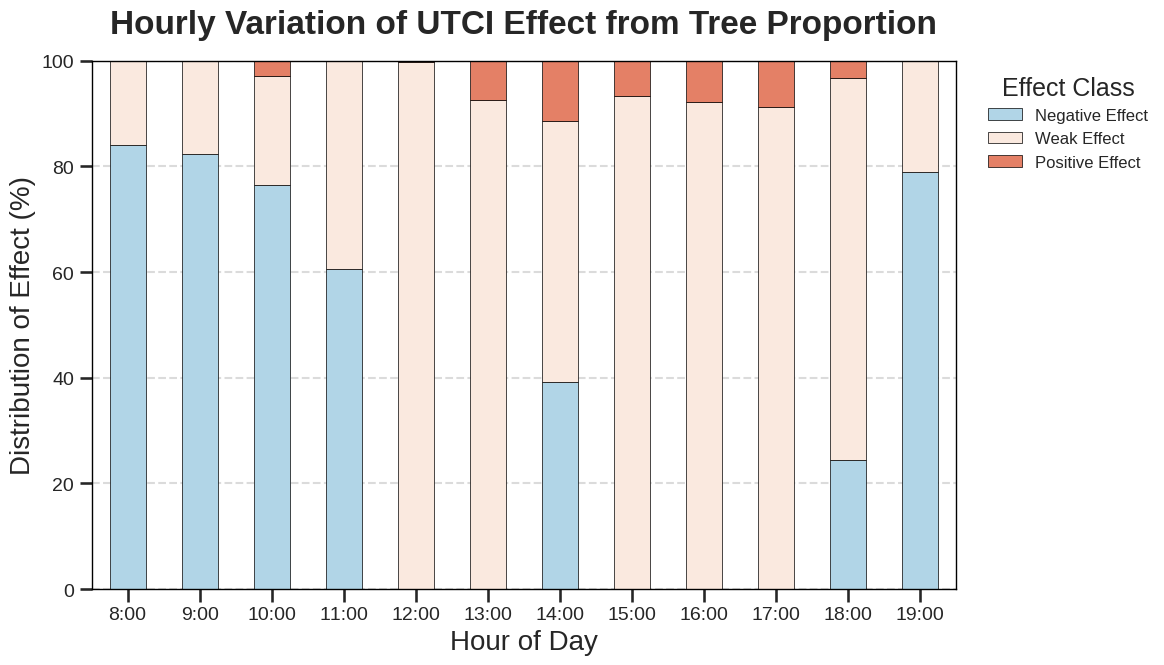

✔️ 图表已保存至: hourly_variation_bar_chart.png

--- 正在生成[箱形图] ---


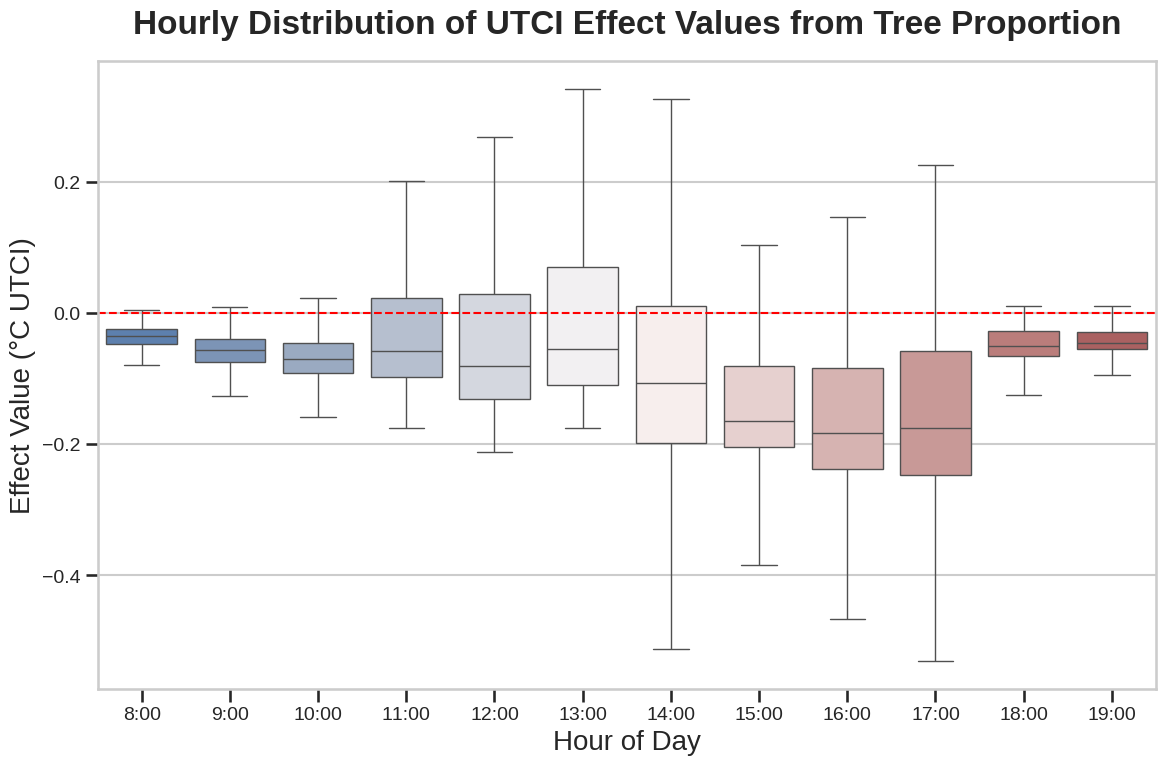

✔️ 图表已保存至: hourly_distribution_boxplot.png

--- 正在准备空间坐标用于热图绘制 ---


ArrowInvalid: No match for FieldRef.Name(x) in pixel_id: int64
hour: int64
X_building_proportion: float
X_mean_building_height: float
X_mean_tree_height: float
X_st1_proportion: float
X_st2_proportion: float
X_st3_proportion: float
X_st5_proportion: float
X_tree_proportion: float
M_MRT: float
M_air_temp: float
M_relative_humidity: float
M_wind_speed: float
Y_utci: float
Z_x_coord: double
Z_y_coord: double
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string

In [ ]:
import numpy as np
import pandas as pd
import joblib
import json
import networkx as nx
import warnings
from pathlib import Path
from tqdm import tqdm
import time

# --- 模型与评估库 ---
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, accuracy_score
from econml.dr import DRLearner
from econml.inference import BootstrapInference

# --- 可视化与空间分析库 ---
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage import find_objects

# =============================================================================
# 1. 配置区域 (Configuration Area)
# =============================================================================
print("--- 1. 配置路径、变量和参数 ---")

# ⭐ 1. 设置您的项目基础路径
DRIVE_BASE_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Graph Data Process")
BASE_ANALYSIS_DIR = DRIVE_BASE_PATH / "Result/0000Contrast_result/causal_analysis"

# --- [输入路径] ---
PANEL_DATA_PATH = BASE_ANALYSIS_DIR / "panel_data_128m.parquet"
FINAL_INFO_DIR = BASE_ANALYSIS_DIR / "step3_final_graphs/final_info_json"
AUTHORITATIVE_SPATIAL_INFO_PATH = BASE_ANALYSIS_DIR / "authoritative_spatial_info_128m.npz"

# --- [模型参数] ---
# ⭐ 2. 选择您想使用的模型: 'XGB' 或 'RF'
MODEL_CHOICE = 'XGB'

# ⭐ 3. 配置统一的、基于比例的分箱策略
N_LINEAR_BINS = 10 # 目标是将所有干预变量都划分为10个等级 (0-9)


# --- [输出路径] ---
ANALYSIS_VERSION = f"step8_final_DRLearner5_{MODEL_CHOICE.lower()}"
OUTPUT_DIR = BASE_ANALYSIS_DIR / ANALYSIS_VERSION
MODELS_DIR = OUTPUT_DIR / "models"
PREPROCESSORS_DIR = OUTPUT_DIR / "preprocessors"
METRICS_DIR = OUTPUT_DIR / "metrics"
HEATMAPS_DIR = OUTPUT_DIR / "heatmaps"
# 确保所有输出目录都存在
for dir_path in [MODELS_DIR, PREPROCESSORS_DIR, METRICS_DIR, HEATMAPS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"[*] 已选择模型: {MODEL_CHOICE}")
print(f"[*] 所有输出将保存至: {ANALYSIS_VERSION}")

# --- [变量定义] ---
X_COLS = [
    'X_mean_tree_height', 'X_mean_building_height', 'X_tree_proportion',
    'X_building_proportion', 'X_st1_proportion', 'X_st2_proportion',
    'X_st3_proportion', 'X_st5_proportion'
]
M_COLS = ['M_air_temp', 'M_wind_speed', 'M_relative_humidity', 'M_MRT']
Y_COLS = ['Y_utci']
Z_COLS = ['Z_x_coord', 'Z_y_coord']


# =============================================================================
# 2. 辅助函数 (Helper Functions)
# =============================================================================

# def consolidate_sparse_bins(t_discrete, min_size):
#     """
#     检查处理组的样本数量，并将所有过于稀疏的高等级组合并。
#     Args:
#         t_discrete (pd.Series): 初始的、离散化的处理组序列。
#         min_size (int): 一个处理组被认为是有效所需的最小样本数。
#     Returns:
#         pd.Series: 一个可能经过合并的、更稳健的处理组序列。
#     """
#     counts = t_discrete.value_counts()
#     sparse_groups = counts[counts < min_size].index

#     # 如果没有稀疏组，或者只有一个稀疏组且它是0组，则无需合并
#     if len(sparse_groups) == 0 or (len(sparse_groups) == 1 and sparse_groups[0] == 0):
#         return t_discrete

#     # 找到需要开始合并的最低处理等级
#     # 我们不合并T=0组，所以从T=1及以上的稀疏组开始
#     sparse_groups_to_merge = [g for g in sparse_groups if g > 0]
#     if not sparse_groups_to_merge:
#         return t_discrete

#     consolidation_level = min(sparse_groups_to_merge)

#     print(f"   [INFO] 发现样本数少于 {min_size} 的稀疏组。")
#     print(f"          将从 T={consolidation_level} 级别开始向上合并...")

#     # 创建一个新的序列，将所有高于或等于合并等级的组合并
#     t_consolidated = t_discrete.copy()
#     t_consolidated[t_discrete >= consolidation_level] = consolidation_level

#     # 重新编码，确保标签是连续的 (0, 1, 2...)
#     t_final, _ = pd.factorize(t_consolidated)

#     return pd.Series(t_final, index=t_discrete.index, name='T_discrete')

def json_to_networkx(graph_data):
    """将JSON图结构转换为networkx.DiGraph对象。"""
    G = nx.DiGraph()
    if 'nodes' in graph_data:
        for node in graph_data['nodes']: G.add_node(node)
    if 'edges' in graph_data:
        for edge in graph_data['edges']:
            if edge.get('type') in ['solid', 'uncertain']:
                G.add_edge(edge['source'], edge['target'])
    return G

def create_spatial_basis_features(df, n_splines=4):
    """从标准化后的空间坐标生成多项式和样条基函数特征。"""
    coords_df = df[Z_COLS]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(coords_df)
    poly_feature_names = [name.replace(' ', '_').replace('^', 'p') for name in poly.get_feature_names_out(Z_COLS)]
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    df_poly_new_only = df_poly.drop(columns=Z_COLS, errors='ignore')
    df_spline = pd.DataFrame(index=df.index)
    for col in Z_COLS:
        knots = np.quantile(df[col], np.linspace(0, 1, n_splines + 2))[1:-1]
        for i, knot in enumerate(knots):
            df_spline[f'spline_{col[-1]}_k{i+1}'] = np.maximum(0, df[col] - knot)
    return pd.concat([df_poly_new_only, df_spline], axis=1)

def define_dml_variables(graph, edge, all_x_cols, all_sb_cols, M_COLS, Y_COLS):
    """根据边的目标节点类型，动态地确定W和X变量集。"""
    source_node, target_node = edge
    t_list, y_list = [source_node], [target_node]
    x_list = [col for col in all_x_cols if col not in t_list] # X是除T外的所有空间形态特征
    w_list = []

    # 规则: W始终包含空间基函数
    w_list.extend(all_sb_cols)

    if target_node in M_COLS:
        # X -> M: W只包含空间基函数
        pass # 已经添加
    elif target_node in Y_COLS:
        # M -> Y: W包含空间基函数 + 所有X特征
        w_list.extend(all_x_cols)
    else: # M -> M
        # 默认回退逻辑: W包含T的父节点 + 空间基函数
        t_parents = list(graph.predecessors(source_node))
        w_list.extend(t_parents)

    # 清洗和去重
    w_list = list(dict.fromkeys(w_list))
    w_list = [v for v in w_list if v not in t_list + y_list]
    x_list = [v for v in x_list if v not in t_list + y_list]

    return {'T': t_list, 'Y': y_list, 'X': x_list, 'W': w_list}

def run_placebo_refuter_discrete(estimator_class, estimator_params, Y, T, X, W):
    """执行安慰剂检验 (离散干预版)。"""
    T_placebo = T.sample(frac=1, random_state=42).values
    # 为安慰剂检验简化参数以加快速度
    placebo_params = estimator_params.copy()
    placebo_params['cv'] = 2
    placebo_params['mc_iters'] = 1

    placebo_estimator = estimator_class(**placebo_params)
    placebo_estimator.fit(Y, T_placebo, X=X, W=W)

    all_placebo_effects = []
    control_group = T.min()
    treatment_groups = sorted([t for t in T.unique() if t != control_group])
    for t1 in treatment_groups:
        placebo_effect_t = placebo_estimator.effect(X=X, T0=control_group, T1=t1)
        all_placebo_effects.append(np.mean(placebo_effect_t))
    return np.mean(all_placebo_effects) if all_placebo_effects else 0

def calculate_auuc_for_binary_comparison(Y, T_binary, cate_estimates):
    """
    为二元处理对比计算AUUC分数。
    Args:
        Y (pd.Series): 仅包含两个对比组的结果变量。
        T_binary (pd.Series): 仅包含两个对比组的二元(0/1)处理变量。
        cate_estimates (np.array): 仅包含两个对比组的CATE估计值。
    """
    from sklearn.linear_model import LinearRegression

    # 将所有输入数据打包成一个DataFrame
    df_eval = pd.DataFrame({
        'Y': Y.values,
        'T': T_binary.values,
        'CATE': cate_estimates.flatten()
    }, index=Y.index)

    df_eval.dropna(inplace=True)
    if len(df_eval) < 20: return np.nan

    # 根据CATE从高到低排序
    df_eval = df_eval.sort_values(by='CATE', ascending=False)

    # 将排序后的数据分成10组
    try:
        df_eval['group'] = pd.qcut(df_eval.index, q=10, labels=False, duplicates='drop')
    except ValueError: # 如果数据太少或分布不均，手动分组
        group_size = len(df_eval) // 10
        if group_size == 0: return np.nan
        df_eval['group'] = np.arange(len(df_eval)) // group_size
        df_eval['group'] = df_eval['group'].clip(upper=9)

    # 计算每个组的真实效应
    actual_effects = []
    for i in range(10):
        group_df = df_eval[df_eval['group'] == i]
        # 确保组内有对照组和处理组的样本
        if len(group_df) < 2 or group_df['T'].nunique() < 2:
            actual_effects.append(0)
            continue
        model = LinearRegression()
        try:
            model.fit(group_df[['T']], group_df['Y'])
            actual_effects.append(model.coef_[0])
        except Exception:
            actual_effects.append(0)

    # 计算并返回AUUC
    uplift_curve = np.cumsum(actual_effects)
    return np.sum(uplift_curve) / len(df_eval)

def visualize_and_save_heatmap(cate_values_1d, pixel_ids, canvas_shape, output_path, title_text):
    """为单次因果对比生成并保存CATE热图。"""
    print(f"   [可视化] 正在生成热图: {title_text} ...")
    try:
        heatmap_2d_full = np.full(canvas_shape, np.nan, dtype=np.float32)
        rows, cols = np.unravel_index(pixel_ids.astype(int), canvas_shape)
        heatmap_2d_full[rows, cols] = cate_values_1d

        bounds = find_objects(np.isfinite(heatmap_2d_full))
        if not bounds:
            print("   [可视化] 警告: 未找到有效数据以生成热图。")
            return
        slice_y, slice_x = bounds[0]
        cropped_heatmap = heatmap_2d_full[slice_y, slice_x]

        valid_pixels = cropped_heatmap[~np.isnan(cropped_heatmap)]
        if valid_pixels.size == 0: return

        v_min, v_max = np.nanpercentile(valid_pixels, 2), np.nanpercentile(valid_pixels, 98)
        abs_max = max(abs(v_min), abs(v_max)) if (v_min != 0 or v_max != 0) else 1
        norm = colors.TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
        cmap = 'RdBu_r'

        aspect_ratio = cropped_heatmap.shape[1] / cropped_heatmap.shape[0]
        fig, ax = plt.subplots(figsize=(12, 12 / aspect_ratio if aspect_ratio > 0 else 12), dpi=250)
        im = ax.imshow(cropped_heatmap, cmap=cmap, norm=norm, interpolation='nearest')

        cbar = fig.colorbar(im, ax=ax, fraction=0.046 * (1 / aspect_ratio), pad=0.04)
        cbar.set_label('CATE (Conditional Average Treatment Effect)', fontsize=12)

        ax.set_title(f"CATE Spatial Distribution\n{title_text}", fontsize=16, pad=20)
        ax.set_xticks([]); ax.set_yticks([])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(output_path, bbox_inches='tight')
        plt.close(fig)
        print(f"   [可视化] 热图已保存至: {output_path}")

    except Exception as e:
        print(f"❌   [可视化] 生成图表时出错: {e}")

# =============================================================================
# 3. 主工作流 (Main Workflow)
# =============================================================================
def estimate_spatial_causal_effects():
    total_start_time = time.time()
    print("\n" + "="*80 + "\n▶️ Part 1: 加载数据...\n" + "="*80)
    try:
        df_full = pd.read_parquet(PANEL_DATA_PATH)
        spatial_info = np.load(AUTHORITATIVE_SPATIAL_INFO_PATH)
        canvas_shape = spatial_info['canvas_shape_128m']
    except Exception as e:
        print(f"❌ 关键错误: 无法加载输入数据文件。请检查路径。错误: {e}")
        return
    print("✅ 数据加载完成。")

    for hour in tqdm(range(8, 20), desc="Overall Progress (Hours)"):
        print("\n" + "="*80 + f"\n▶️ Part 2: Processing Hour {hour}:00 ...\n" + "="*80)

        df_hour_original = df_full[df_full['hour'] == hour].copy().sort_values(by='pixel_id').reset_index(drop=True)
        if df_hour_original.empty:
            print(f"   [警告] 小时 {hour} 没有数据，跳过。")
            continue

        # --- 预处理与存档 ---
        scaler = StandardScaler()
        cols_to_standardize = [col for col in df_hour_original.columns if col not in ['hour', 'pixel_id']]
        df_hour_std = df_hour_original.copy()
        df_hour_std[cols_to_standardize] = scaler.fit_transform(df_hour_original[cols_to_standardize])

        scaler_path = PREPROCESSORS_DIR / f"scaler_hour_{hour}.joblib"
        joblib.dump(scaler, scaler_path)
        print(f"[*] 小时 {hour} 的标准化预处理器已保存。")

        df_spatial_features = create_spatial_basis_features(df_hour_std)
        SB_COLS = list(df_spatial_features.columns)

        final_info_path = FINAL_INFO_DIR / f'final_info_hour_{hour}.json'
        if not final_info_path.exists():
            print(f"   [警告] 小时 {hour} 的因果图未找到，跳过。")
            continue
        with open(final_info_path, 'r') as f: graph_data = json.load(f)
        causal_graph = json_to_networkx(graph_data)
        print(f"[*] 小时 {hour} 的因果图加载成功，包含 {len(causal_graph.edges())} 条边。")

        for i, edge in enumerate(tqdm(causal_graph.edges(), desc=f"Processing Edges for Hour {hour}")):
            source_node, target_node = edge
            print(f"\n--- [Edge {i+1}/{len(causal_graph.edges())}] Processing: {source_node} -> {target_node} ---")

            if target_node in Y_COLS:
                print("   [跳过] 根据策略，跳过所有指向最终结果Y的边。")
                continue

            try:
                # --- A. 在标准化尺度上进行统一的线性分箱 (全新最终逻辑) ---
                T_name = source_node

                # 1. 从已经标准化的数据框中，提取出干预变量 T
                T_standardized = df_hour_std[T_name]

                # 2. 获取其在标准化尺度上的最大值和最小值
                min_val = T_standardized.min()
                max_val = T_standardized.max()

                # 3. 创建 N 个等间隔的线性分箱
                #    np.linspace会生成 N+1 个边界点
                bins = np.linspace(min_val, max_val, N_LINEAR_BINS + 1)

                # 4. 为了确保覆盖所有数据，稍微扩大边界
                bins[0] = -np.inf
                bins[-1] = np.inf

                # 5. 使用pd.cut进行分箱，得到最终的 T_discrete
                T_discrete = pd.cut(T_standardized, bins=bins, labels=False, right=True, include_lowest=True)

                # 6. 使用最终的处理组来确定类别数量
                num_classes = T_discrete.nunique()

                if num_classes <= 1:
                    print("   [跳过] 干预变量离散化后只有一个类别，无法进行因果分析。")
                    continue

                # --- B. 定义变量集 ---
                variables = define_dml_variables(causal_graph, edge, X_COLS, SB_COLS, M_COLS, Y_COLS)
                Y_name, X_names, W_names = variables['Y'][0], variables['X'], variables['W']

                Y = df_hour_std[Y_name]
                X = df_hour_std[X_names] if X_names else None

                # --- [核心修复] 重构W的构建逻辑 ---
                # 1. 从 W_names 中找出确实存在于主数据框 df_hour_std 的列
                w_names_from_main_df = [w for w in W_names if w in df_hour_std.columns]

                # 2. 安全地从主数据框中提取这些列
                w_df_from_main = df_hour_std[w_names_from_main_df] if w_names_from_main_df else pd.DataFrame(index=df_hour_std.index)

                # 3. 最后，将这部分与独立的空间特征数据框合并，构成完整的 W
                W = pd.concat([w_df_from_main, df_spatial_features], axis=1)
                # --- 修复结束 ---

                W = W.loc[:, ~W.columns.duplicated()] # 保留这行去重逻辑，是好的实践

                # --- C. 实例化并训练模型 ---
                if MODEL_CHOICE == 'RF':
                    model_reg = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42, n_jobs=-1)
                    model_clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=50, random_state=42, n_jobs=-1)
                else: # XGBoost is the default
                    xgb_params = {'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 10, 'random_state': 42, 'n_jobs': -1}
                    model_reg = xgb.XGBRegressor(**xgb_params)
                    model_clf = xgb.XGBClassifier(**{**xgb_params, 'objective': 'multi:softprob', 'num_class': num_classes})

                dr_learner_params = {'model_regression': model_reg, 'model_propensity': model_clf, 'cv': 5, 'mc_iters': 3, 'random_state': 42}
                dr_learner = DRLearner(**dr_learner_params)
                dr_learner.fit(Y, T_discrete, X=X, W=W)
                print("   [成功] DRLearner 模型训练完成。")

                # --- D. 全面评估、存档与可视化 ---
                all_metrics = {'hour': hour, 'treatment': T_name, 'outcome': Y_name, 'model_choice': MODEL_CHOICE}
                all_metrics['r2_y'] = np.mean(dr_learner.nuisance_scores_[0])
                all_metrics['accuracy_t'] = np.mean(dr_learner.nuisance_scores_[1])
                all_metrics['placebo_ace'] = run_placebo_refuter_discrete(DRLearner, dr_learner_params, Y, T_discrete, X, W)

                control_group = T_discrete.min()
                treatment_groups = sorted([t for t in T_discrete.unique() if t != control_group])
                all_metrics['ates'] = {}
                all_metrics['auucs'] = {} # <-- [新增] 初始化AUUCs字典

                edge_name_fs = f"{T_name}_to_{Y_name}" # File-safe edge name

                for t1 in treatment_groups:
                    ate_key = f'T={t1}_vs_T={control_group}'

                    # --- 计算CATE和ATE (已有代码) ---
                    cate_t1_vs_t0 = dr_learner.effect(X=X, T0=control_group, T1=t1)
                    all_metrics['ates'][ate_key] = np.mean(cate_t1_vs_t0)

                    # --- [新增] 计算对应的AUUC ---
                    print(f"   [评估] 正在为 {ate_key} 计算 AUUC...")
                    # 1. 筛选出只包含这两个对比组的数据
                    mask = T_discrete.isin([control_group, t1])
                    Y_subset = Y[mask]
                    T_discrete_subset = T_discrete[mask]
                    cate_subset = cate_t1_vs_t0[mask]

                    # 2. 创建一个二元的(0/1)处理变量
                    T_binary_subset = (T_discrete_subset == t1).astype(int)

                    # 3. 调用函数计算AUUC
                    auuc_score = calculate_auuc_for_binary_comparison(Y_subset, T_binary_subset, cate_subset)
                    all_metrics['auucs'][ate_key] = auuc_score
                    # --- AUUC计算结束 ---

                    # --- 可视化 (已有代码) ---
                    title = f"Hour {hour} | {T_name} -> {Y_name}\n({ate_key})"
                    heatmap_path = HEATMAPS_DIR / f"heatmap_hour{hour}_{edge_name_fs}_{ate_key.replace('=', '').replace(' ', '')}.png"
                    visualize_and_save_heatmap(cate_t1_vs_t0, df_hour_original['pixel_id'].values, canvas_shape, heatmap_path, title)

                # --- 更新的调试打印模块 ---
                print("\n   --- [Debug Info] Current Edge Performance ---")
                print(f"     - Y-Model R² (OOS):         {all_metrics.get('r2_y', 'N/A'):.4f}")
                print(f"     - T-Model Accuracy (OOS):   {all_metrics.get('accuracy_t', 'N/A'):.4f}")
                print(f"     - Placebo ACE:              {all_metrics.get('placebo_ace', 'N/A'):.4f}")
                if 'ates' in all_metrics and all_metrics['ates']:
                    print("     - Average Treatment Effects (ATEs) & AUUCs:")
                    for ate_key, ate_value in all_metrics['ates'].items():
                        auuc_value = all_metrics.get('auucs', {}).get(ate_key, 'N/A')
                        auuc_str = f"{auuc_value:.4f}" if isinstance(auuc_value, (int, float)) else auuc_value
                        print(f"       - {ate_key}: {ate_value:<8.4f} | AUUC: {auuc_str}")
                print("   -------------------------------------------")

                # 存档
                model_path = MODELS_DIR / f"drlearner_hour{hour}_{edge_name_fs}.joblib"
                metrics_path = METRICS_DIR / f"metrics_hour{hour}_{edge_name_fs}.json"
                joblib.dump(dr_learner, model_path)
                with open(metrics_path, 'w') as f: json.dump(all_metrics, f, indent=4)

                print(f"   [存档] 模型与指标已成功保存。")
                print(f"   [报告] Y-Model R²: {all_metrics['r2_y']:.4f}, T-Model Accuracy: {all_metrics['accuracy_t']:.4f}")

            except Exception as e:
                import traceback
                print(f"❌ 错误: 处理边 {source_node} -> {target_node} 失败。")
                traceback.print_exc()
                continue

    total_duration = time.time() - total_start_time
    print(f"\n🎉 全时段工作流完成！总耗时: {total_duration / 60:.2f} 分钟。")

if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning, module='econml')
    estimate_spatial_causal_effects()